## Jalin Roberts | Preliminary Predictive Analytics Model.
## Stock Price Forecasting utilizing ARIMA (Auto-Regressive Integrated Moving Average).
## Purpose of Model: Forecast Adjusted Closing Price for each stock as accurately as possible.

---

## Data Preparation and Initial Analysis

### Importing Necessary Libraries
The script begins by importing various Python libraries necessary for time series analysis and model development:
- **Pandas and NumPy**: For data manipulation and handling.
- **Statsmodels**: Provides tools for statistical modeling, including the ARIMA model and statistical tests.
- **Scikit-Learn**: Offers functions for calculating model performance metrics.
- **Matplotlib, Seaborn, and Plotly**: For data visualization.
- **Warnings**: To suppress warnings during execution.

### Loading and Displaying the Data
The .csv file contains ONLY the adjusted closing price for each stock, this is for accuracy and ease-of-use

```python
# Allocate the file path correctly as per the dataset location, simply making a note of this as it is a simple mistake I have made before
data_file_path = '/Applications/Bellarmine DS Spring 2024/DS Senior Capstone/Final Project/merged_stocks_new.csv'
df = pd.read_csv(data_file_path)
df.head()
```


### General Points to Note for this model and code:
- **New File**: It's important to note that the dataset in this file only includes information for Adjusted Close Price, and as a result a new Excel file was created that contains only this information. If I were trying to predict more than one variable, I would pre-process the data differently.
- **Model Notes**: For the model fitting and evaluation, the X-Axis ranges from 0-250, this is because the testing data is around 250 (the number of trading days in a given year) This is also testing for year 2023 based on 2018-2022 training data.
- **Code Explanation and Markdown Cells**: This project is built in such a way that I will be able to understand each step of the ARIMA model building process. The notes, explanations, and code breakdown are not transferrable to all skillsets. Not all code utilized in this project is explained, and this project was built in such a way to streamline the ARIMA model building process as much as possible. Information and sources used for this project give heavily varied advice and suggestions, making the process very complicated to understand what is/is not best practice(s).
- **Complexity**: Due to the amount of conflicting information on ARIMA code, models, accuracy testing, and robustness/validity; Having a 'solid' foundation of ARIMA/SARIMAX models is not possible in this length of time. Some cells of this project contain extensive amounts of code, more than I am comfortable with having in individual code cells. This model was a 10/10 in terms of difficulty for me, and as a result I can not professional articulate every single line of code. I did my best to convey as much of the process as possible, however my learning experience with ARIMA is still very much in-progress.

### Important point to consider:
- **ARIMA Outputs**: The ARIMA outputs and subsequent plots are meant to give a visual and textual representation of model predictions. However, ARIMA does not output if the time series is stationary or other tests like autocorrelation. This has to be built and visualized. I made sure to include these in the outputs during the testing. Currently, there is not an extensive amount of comments on the results/outputs, as the purpose was to get the model to run correctly first.
---


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Load Excel File
data_file_path = '/Applications/Bellarmine DS Spring 2024/DS Senior Capstone/Final Project/merged_stocks_new.csv'
df = pd.read_csv(data_file_path)

df['Date'] = pd.to_datetime(df['Date'])  # Parsing the 'timestamp' column
df.set_index('Date', inplace=True)           # Setting the parsed 'timestamp' as the index

# Display the first few rows of the dataset to understand its structure
df.head()

SPY       CBSH   CSTM         IWM        META       MSFT  \
Date                                                                          
2018-01-02  243.072281  43.791382  11.45  142.351120  181.419998  80.229004   
2018-01-03  244.609741  43.611351  11.65  142.499130  184.669998  80.602371   
2018-01-04  245.640732  43.564407  11.95  142.878372  184.330002  81.311806   
2018-01-05  247.277756  43.900959  11.80  143.174377  186.850006  82.319908   
2018-01-08  247.729965  43.619186  11.85  143.396408  188.279999  82.403931   

                  PWR         QQQ        SRE       TSLA  
Date                                                     
2018-01-02  38.584988  152.072769  36.394047  21.368668  
2018-01-03  38.889820  153.550415  37.357880  21.150000  
2018-01-04  39.194633  153.819077  37.109146  20.974667  
2018-01-05  38.850483  155.363892  37.464970  21.105333  
2018-01-08  38.447323  155.968353  37.475334  22.427334

#### 1. Checking for NaNs in the Dataset

```python
print("Checking for NaNs in the dataset:")
print(df.isna().sum())
```

- **Purpose**: This section of the script is used to identify and count the number of missing values (NaNs) in each column of the dataset `df`. It is a crucial step in data preprocessing to ensure the quality and integrity of the data before performing any analysis or model training.
- **How it works**: The `isna()` method is called on the DataFrame `df` to create a boolean mask where True represents NaN values. The `sum()` method is then applied to this mask to count the number of True values (i.e., NaNs) in each column. These counts are printed to the console, providing a column-wise summary of missing values.

#### 2. Filling NaNs with the Previous Value

```python
df.fillna(method='ffill', inplace=True)
```

- **Purpose**: This line is responsible for filling missing values in the dataset. Instead of leaving NaNs, which can be problematic for many data analysis and machine learning algorithms, it replaces each NaN with the last valid observation in the same column.
- **How it works**: The `fillna()` method is used with the `method='ffill'` argument, which stands for 'forward fill'. This means that each NaN value in a column will be replaced with the nearest preceding non-NaN value in that column. The `inplace=True` argument modifies the DataFrame `df` in place, meaning the changes are made directly to `df` without needing to create a copy.

#### 3. Checking if NaNs Have Been Successfully Filled

```python
print("\nNaNs after filling:")
print(df.isna().sum())
```

- **Purpose**: After filling the NaN values, this section rechecks the dataset to ensure that all NaNs have been successfully replaced. This step verifies the effectiveness of the NaN filling process.
- **How it works**: Similar to the initial check for NaNs, the `isna().sum()` method is used again to count NaNs across all columns of the modified DataFrame `df`. Ideally, all counts should now be 0, indicating that there are no longer any missing values.

#### 4. Checking for Zero Values in the Dataset

```python
print("\nChecking for zero values in the dataset:")
print((df == 0).sum())
```

- **Purpose**: This part of the script identifies and counts the number of zero values in each column of the dataset. Zero values may be significant in certain contexts (e.g., indicating absence or null activity) and may require special consideration depending on the analysis or modeling goals.
- **How it works**: A boolean comparison `(df == 0)` is used to create a mask where True represents cells with a value of 0. Applying `sum()` to this mask counts the number of True values (i.e., zeros) in each column, providing insight into the distribution of zero values in the dataset.

#### 5. Displaying the First Few Rows of the Dataset

```python
df.head()
```

- **Purpose**: This command is used to display the first few rows of the DataFrame `df`. It helps in understanding the structure, data types, and content of the dataset at a glance, which is vital for further data analysis and preprocessing steps.
- **How it works**: The `head()` method displays the top rows of the DataFrame (5 rows by default). This visual inspection can be crucial for verifying data integrity, understanding column formats, and gaining initial insights into the dataset's potential features and values.

In [4]:
# Check for NaNs in the dataset
print("Checking for NaNs in the dataset:")
print(df.isna().sum())

# Filling NaNs (if any) with the previous value in the dataset
df.fillna(method='ffill', inplace=True)

# Check if NaNs have been successfully filled
print("\nNaNs after filling:")
print(df.isna().sum())

# Check for zero values in the dataset
print("\nChecking for zero values in the dataset:")
print((df == 0).sum())

# Display the first few rows of the dataset to understand its structure
df.head()

Checking for NaNs in the dataset:
SPY     0
CBSH    0
CSTM    0
IWM     0
META    0
MSFT    0
PWR     0
QQQ     0
SRE     0
TSLA    0
dtype: int64

NaNs after filling:
SPY     0
CBSH    0
CSTM    0
IWM     0
META    0
MSFT    0
PWR     0
QQQ     0
SRE     0
TSLA    0
dtype: int64

Checking for zero values in the dataset:
SPY     0
CBSH    0
CSTM    0
IWM     0
META    0
MSFT    0
PWR     0
QQQ     0
SRE     0
TSLA    0
dtype: int64


SPY       CBSH   CSTM         IWM        META       MSFT  \
Date                                                                          
2018-01-02  243.072281  43.791382  11.45  142.351120  181.419998  80.229004   
2018-01-03  244.609741  43.611351  11.65  142.499130  184.669998  80.602371   
2018-01-04  245.640732  43.564407  11.95  142.878372  184.330002  81.311806   
2018-01-05  247.277756  43.900959  11.80  143.174377  186.850006  82.319908   
2018-01-08  247.729965  43.619186  11.85  143.396408  188.279999  82.403931   

                  PWR         QQQ        SRE       TSLA  
Date                                                     
2018-01-02  38.584988  152.072769  36.394047  21.368668  
2018-01-03  38.889820  153.550415  37.357880  21.150000  
2018-01-04  39.194633  153.819077  37.109146  20.974667  
2018-01-05  38.850483  155.363892  37.464970  21.105333  
2018-01-08  38.447323  155.968353  37.475334  22.427334

### EDA of Newly Created Dataset

```python
print("\nSummary Statistics:")
print(df.describe())
```
This section of the script is designed to provide a statistical summary of the dataset `df`. It aims to give a quick overview of the central tendency, dispersion, and shape of the dataset's distribution, excluding NaN values. This step is crucial for understanding the data's characteristics, identifying outliers, and making informed decisions on further data preprocessing and analysis.

The Reason for the EDA is that I changed the Excel file to only have 'Adjusted Close' values for each of the 10 stocks, it is purely just for a quick double-check to make sure everything is there.

#### How it Works
- **`df.describe()`**: This method generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution, excluding NaN values. By default, `describe()` includes statistics for numeric columns only. These statistics include:
  - **count**: The number of non-NaN entries in each column.
  - **mean**: The mean value of each column.
  - **std**: The standard deviation of each column, indicating the dispersion of data points.
  - **min**: The minimum value in each column.
  - **25% (first quartile)**: The value below which 25% of the data falls.
  - **50% (median)**: The middle value, dividing the dataset into two halves. It is also the second quartile.
  - **75% (third quartile)**: The value below which 75% of the data falls.
  - **max**: The maximum value in each column.

- **Printing the Statistics**: The summary statistics generated by `describe()` are printed to the console, providing an easily accessible overview of the dataset's statistical properties.

#### Significance
- **Data Insights**: The summary statistics offer valuable insights into the nature of the dataset, including the range of values, central values, and variability. Understanding these aspects is essential for identifying potential data quality issues, such as outliers or incorrectly entered data.
- **Guidance for Further Analysis**: The information obtained from the summary statistics can guide further data preprocessing steps, such as normalization or standardization, and inform about suitable statistical tests or machine learning algorithms based on the distribution of the data.
- **Initial Data Check**: This step serves as an initial check to understand the dataset better before diving deeper into analysis or modeling. It helps in identifying columns that require further investigation or preprocessing.

In [5]:
# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
               SPY         CBSH         CSTM          IWM         META  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean    342.705646    56.848522    13.282863   169.071485   225.102942   
std      74.183657     8.439090     3.711875    28.746052    68.229158   
min     210.584885    39.276642     4.130000    94.767609    88.910004   
25%     267.276093    49.684650    10.430000   145.661118   174.600006   
50%     352.968109    54.149887    13.120000   166.413422   202.160004   
75%     409.171967    65.465668    16.620001   189.640823   280.829987   
max     476.690002    73.419411    21.250000   234.878174   382.179993   

              MSFT          PWR          QQQ          SRE         TSLA  
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000  
mean    209.051196    86.528509   264.619278    56.902392   145.981504  
std      84.244220    54.938313    78.828507    12.248253   113.530192  
min      79.351585  

### Plotting Numerical Features

#### 1. Identifying Numerical Features

```python
num_features = df.select_dtypes(include=[np.number]).columns
```

- **Purpose**: This line filters the columns of the DataFrame `df` to identify those that are numerical. It creates a list of column names for features with numeric data types, which will be used for the subsequent plotting.
- **How it Works**: The `select_dtypes(include=[np.number])` method is used to select columns whose data type is numerical (integers and floats). The `.columns` attribute then extracts the column names.

#### 2. Histograms for Numerical Features

```python
for col in num_features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col].values, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()
```

- **Purpose**: Histograms are used to visualize the distribution of each numerical feature in the dataset. This visualization helps in understanding the shape of the data distribution, such as whether it is normal, skewed, or has any peculiar patterns.
- **How it Works**: For each numerical feature, a histogram is plotted using `plt.hist()`. The `bins` parameter defines the number of intervals or "bins" the data range is divided into. The `edgecolor` and `alpha` parameters are used to enhance the visual appeal of the histogram.

#### 3. Boxplots for Numerical Features

```python
for col in num_features:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col].dropna().values)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()
```

- **Purpose**: Boxplots provide a graphical representation of the distribution of each numerical feature, highlighting the median, quartiles, and outliers. This is essential for identifying outliers and understanding the variability in the data.
- **How it Works**: For each numerical column, `plt.boxplot()` is used to create a boxplot. The `.dropna()` method ensures that NaN values are excluded from the plot, as they cannot be visualized.

#### 4. Correlation Matrix Heatmap

```python
plt.figure(figsize=(10, 8))
plt.imshow(df.corr(), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(df.corr().columns)), df.corr().columns, rotation='vertical')
plt.yticks(range(len(df.corr().columns)), df.corr().columns)
plt.title('Correlation Matrix')
plt.show()
```

- **Purpose**: The correlation matrix heatmap visualizes the pairwise correlation coefficients between numerical features. This is crucial for identifying potential relationships or dependencies between variables.
- **How it Works**: `df.corr()` computes the correlation matrix. `plt.imshow()` is then used to display the matrix as a heatmap. The `cmap='coolwarm'` parameter defines the color map to visually distinguish high (warm) and low (cool) correlation values.

#### 5. Scatter Plots for Numerical Features

```python
for i, col1 in enumerate(num_features):
    for j, col2 in enumerate(num_features):
        if i < j:
            plt.figure(figsize=(6, 4))
            plt.scatter(df[col1], df[col2], alpha=0.5)
            plt.title(f'{col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.grid(True)
            plt.show()
```

- **Purpose**: Scatter plots are used to explore the relationships between pairs of numerical features. They can reveal patterns, trends, or correlations between variables.
- **How it Works**: Nested loops iterate over pairs of numerical features to plot scatter plots, ensuring that each pair is plotted only once (`if i < j`). The `plt.scatter()` function creates the scatter plot, with the `alpha` parameter controlling the transparency of the points to help visualize data density.

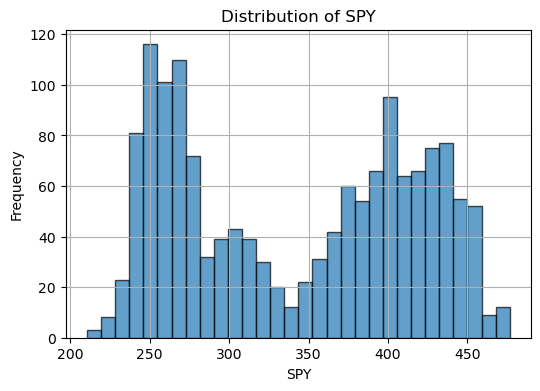

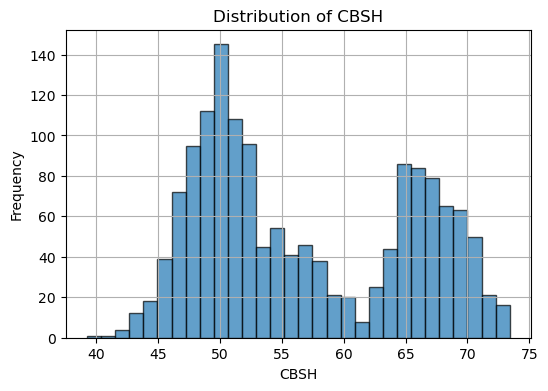

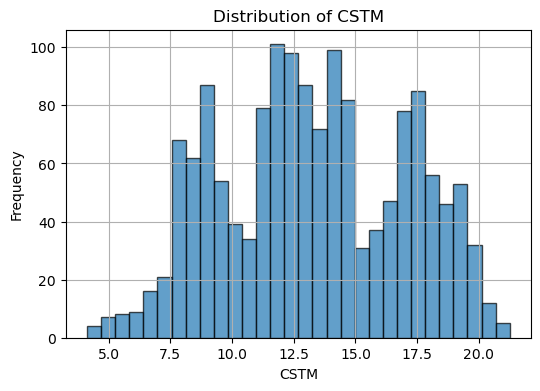

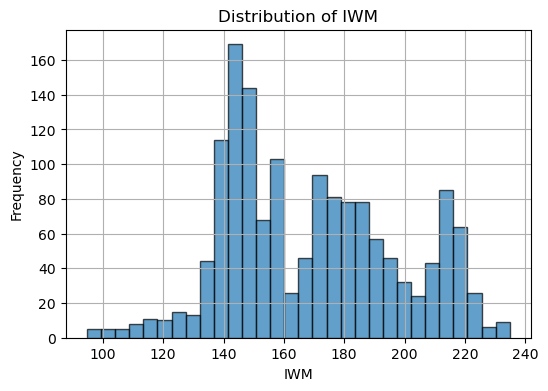

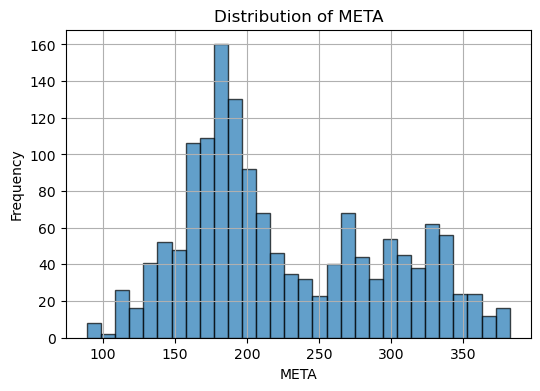

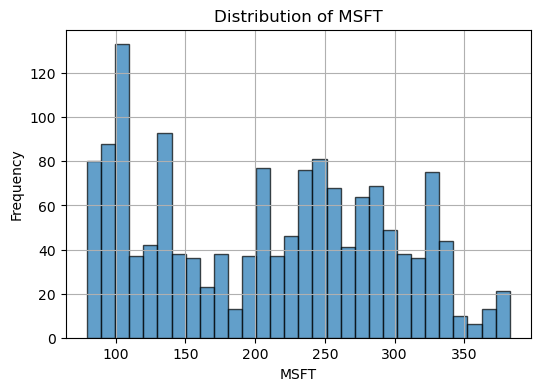

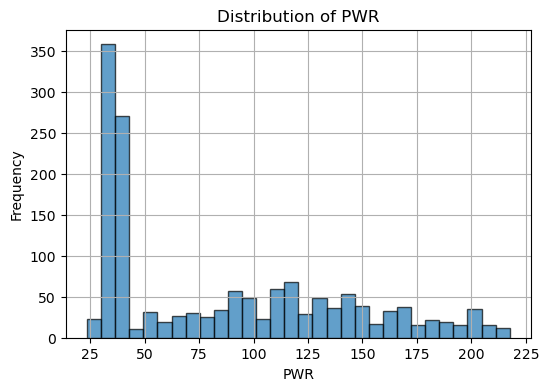

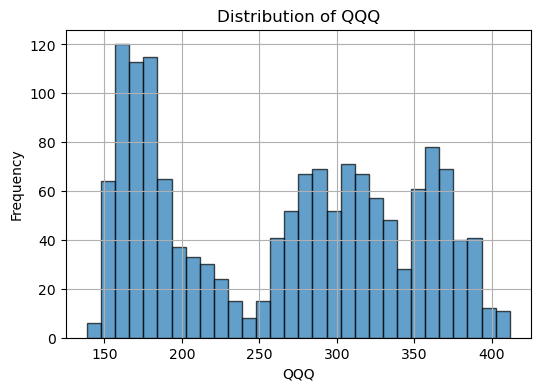

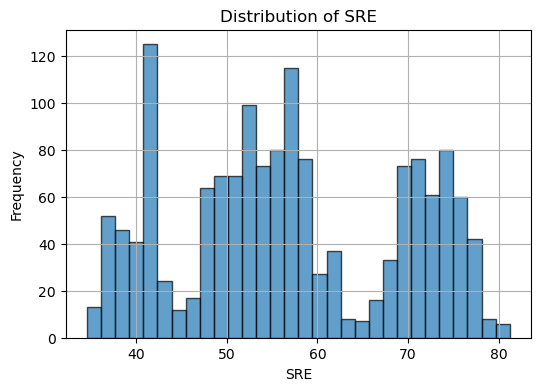

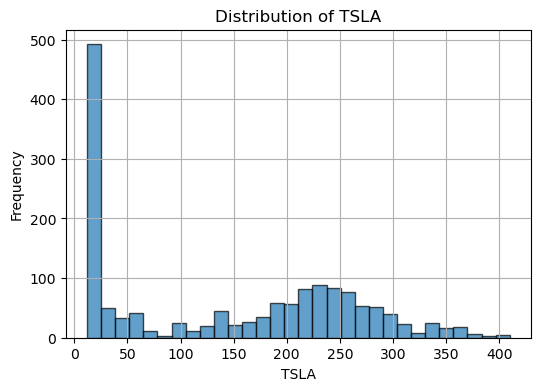

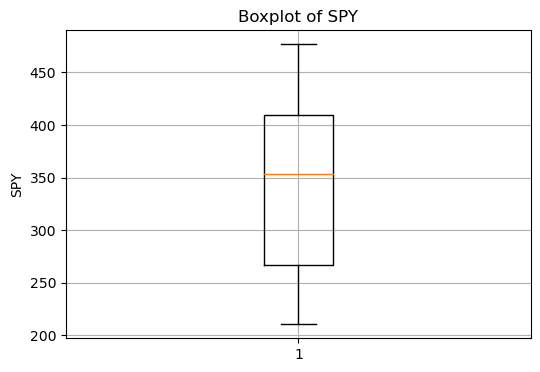

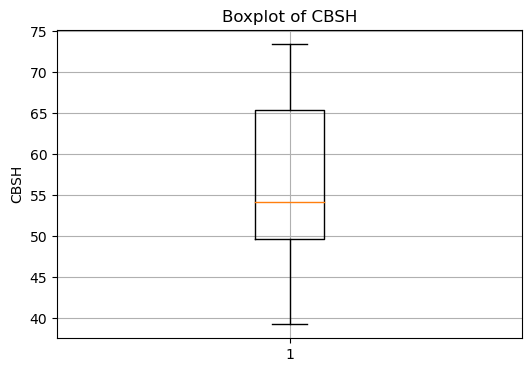

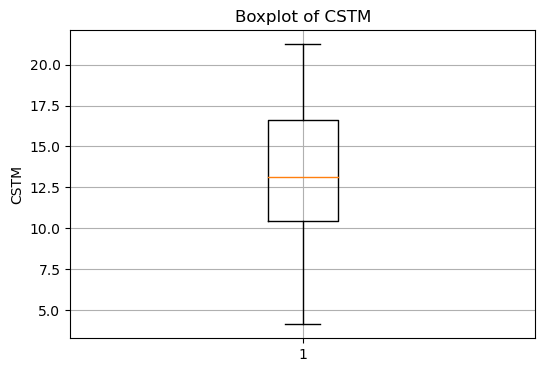

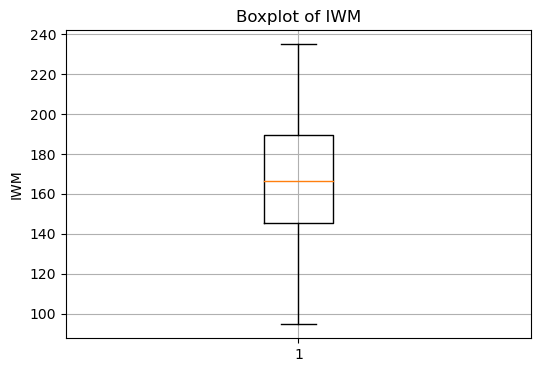

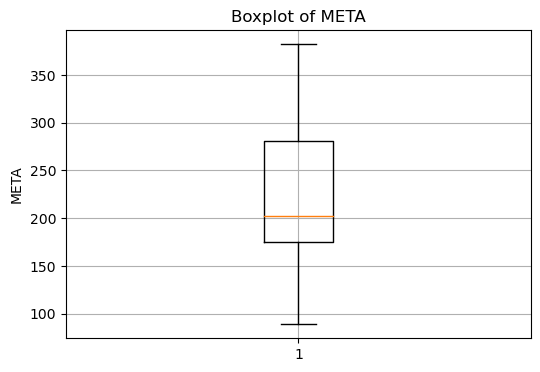

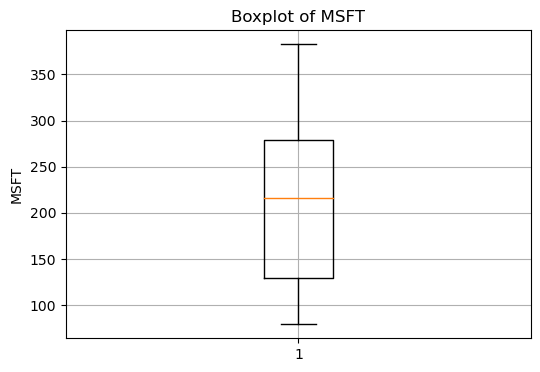

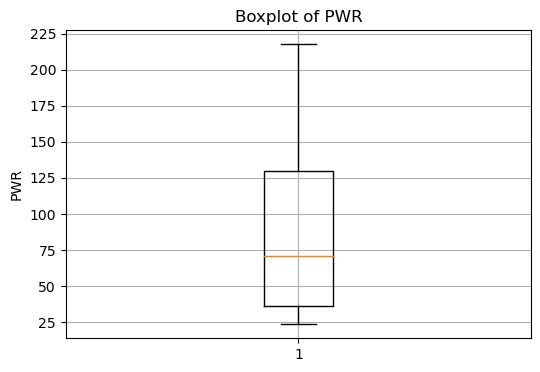

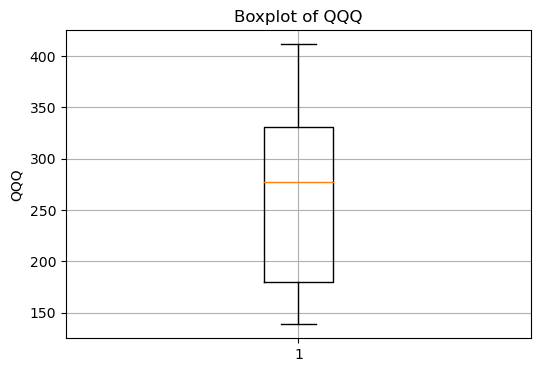

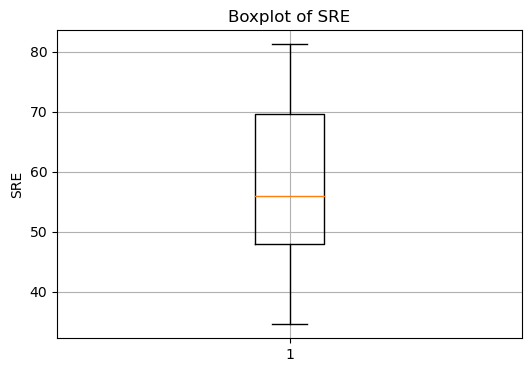

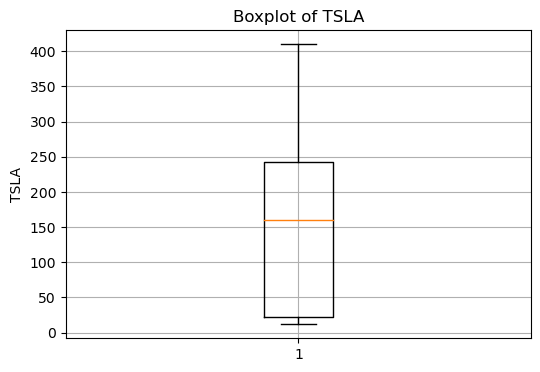

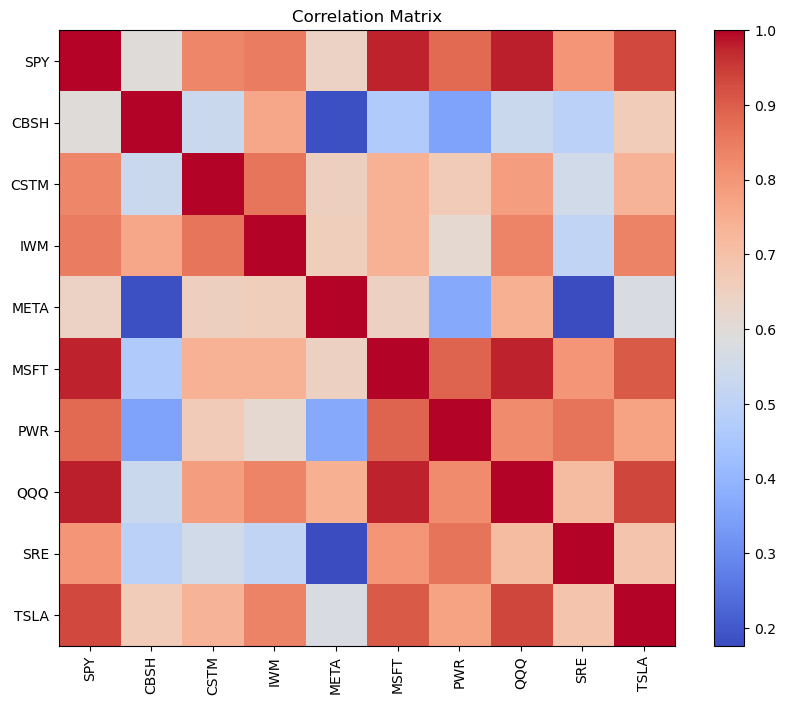

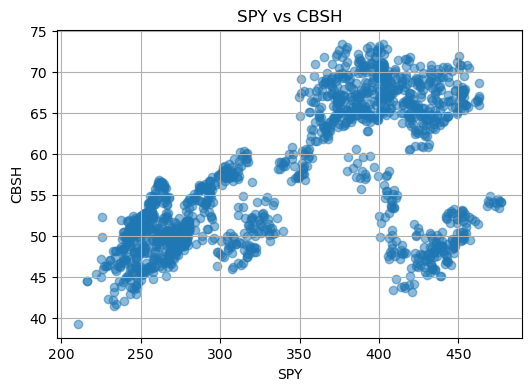

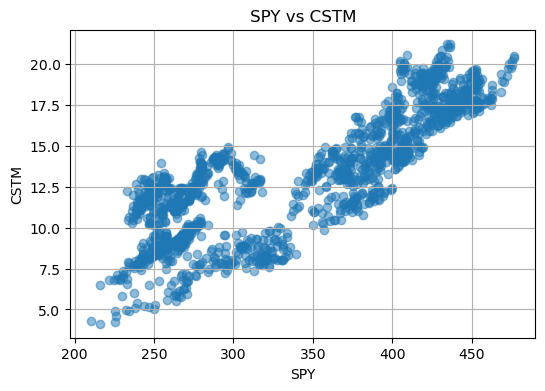

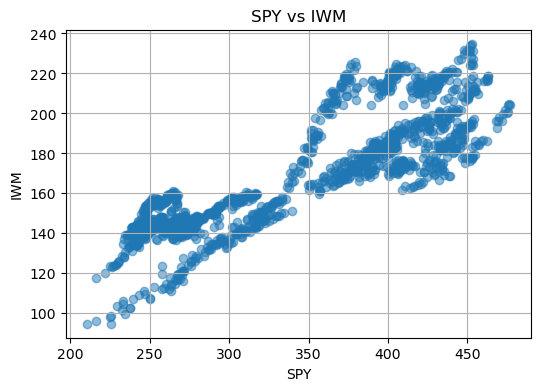

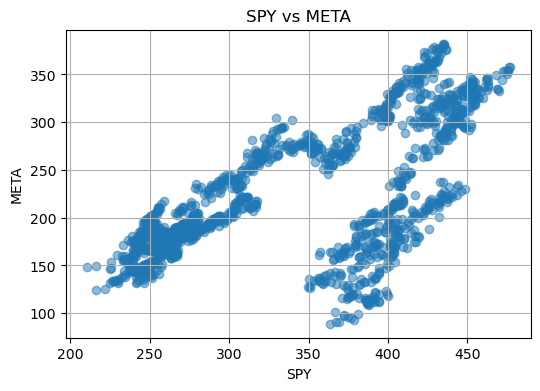

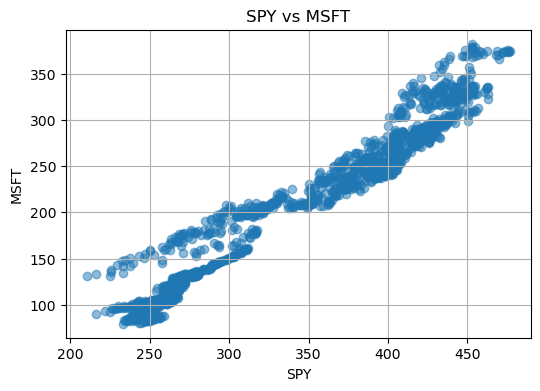

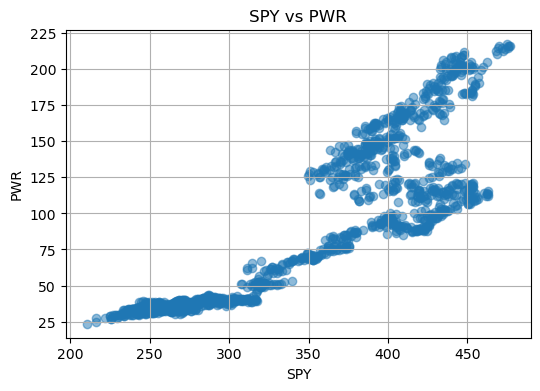

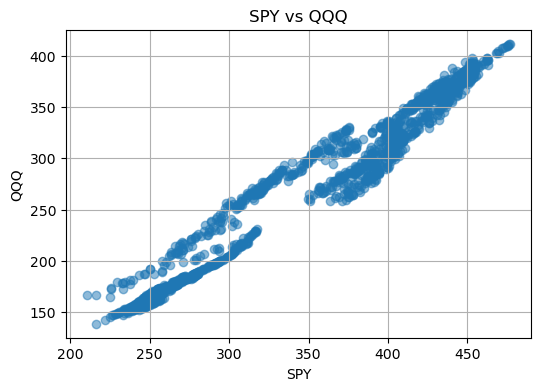

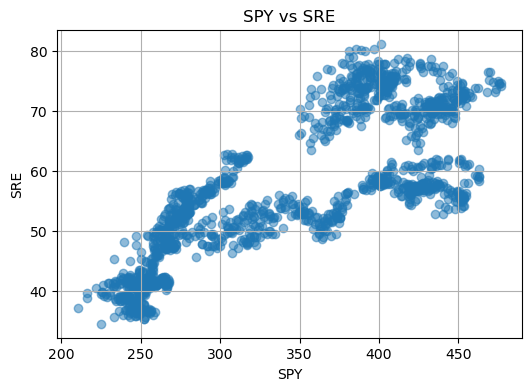

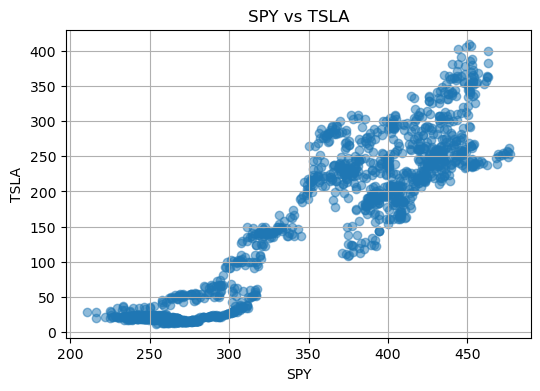

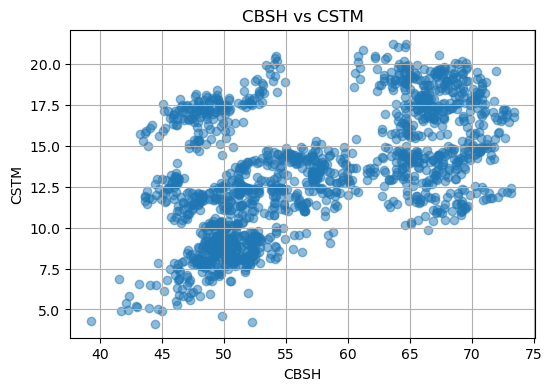

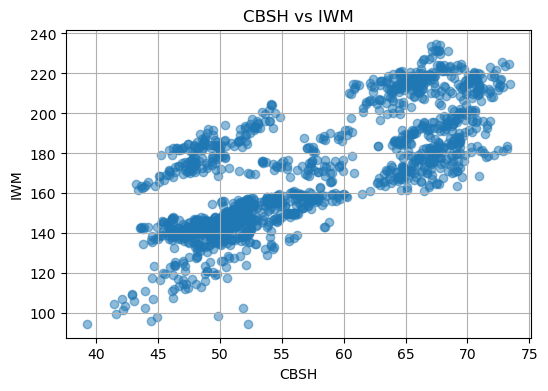

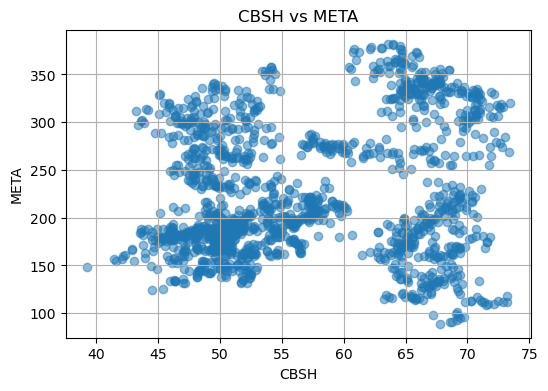

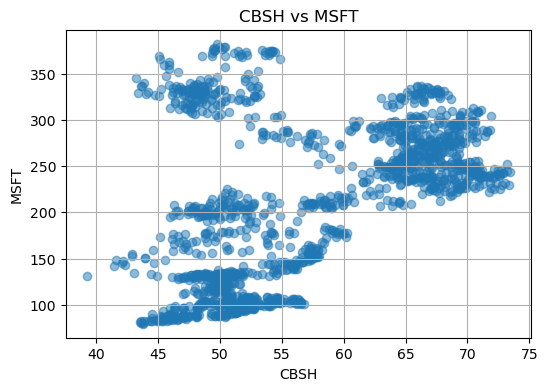

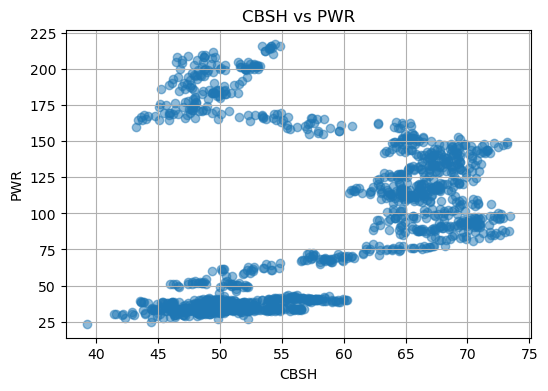

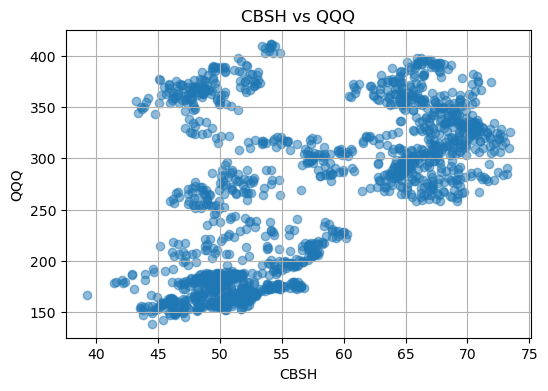

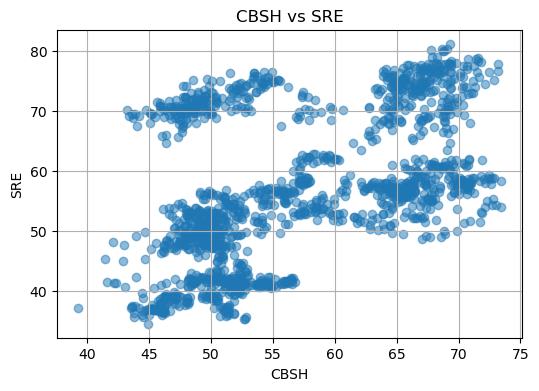

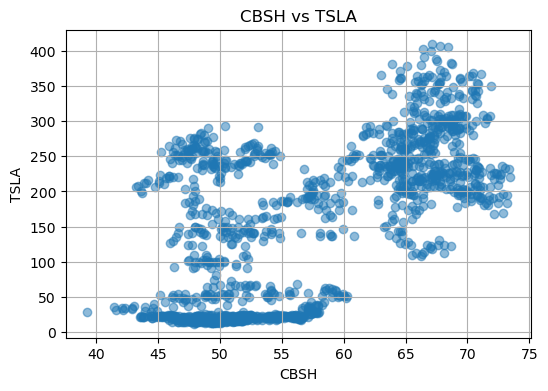

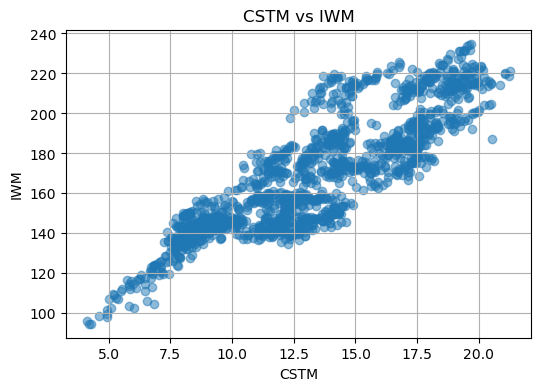

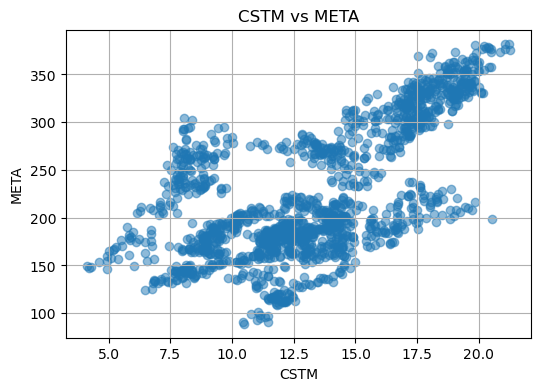

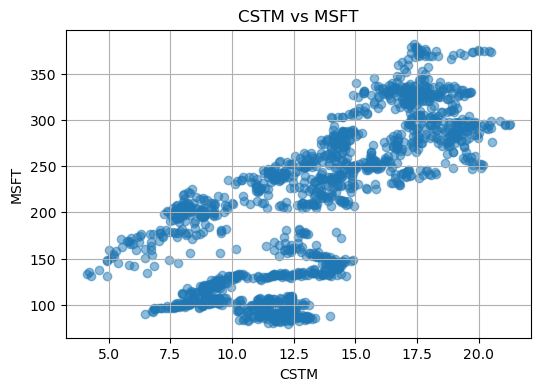

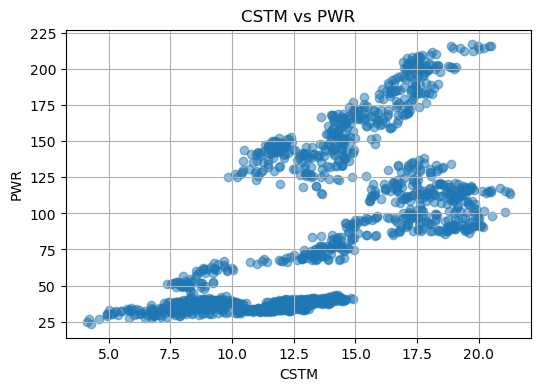

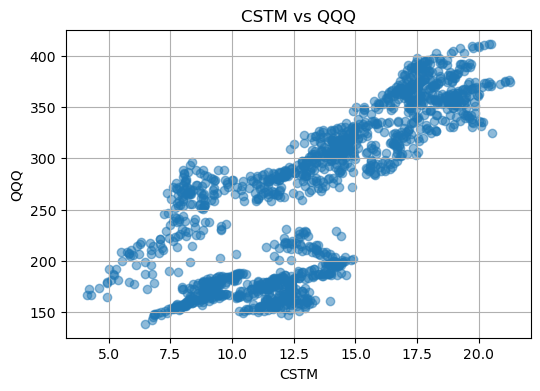

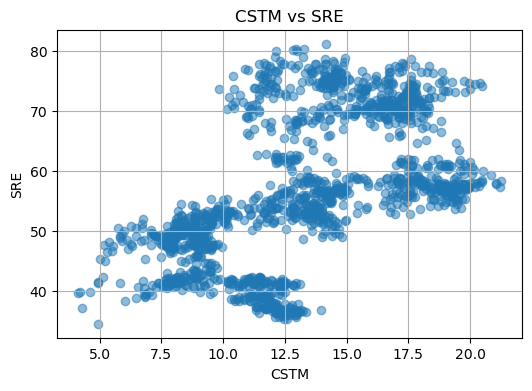

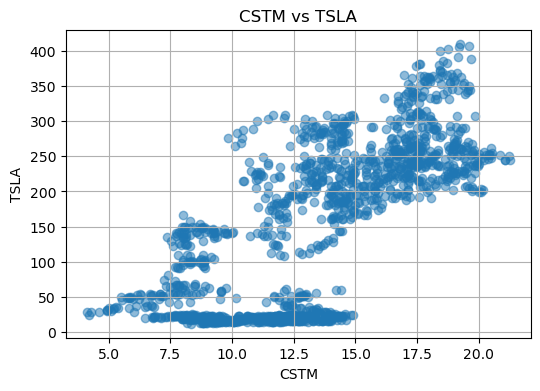

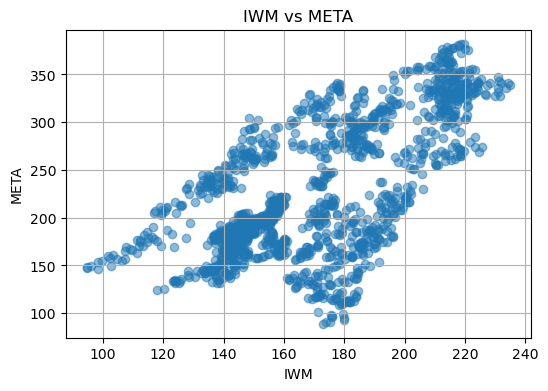

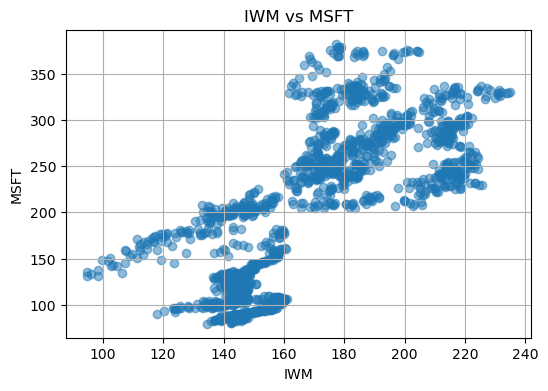

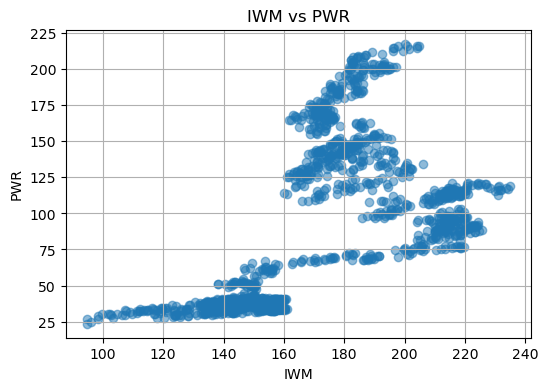

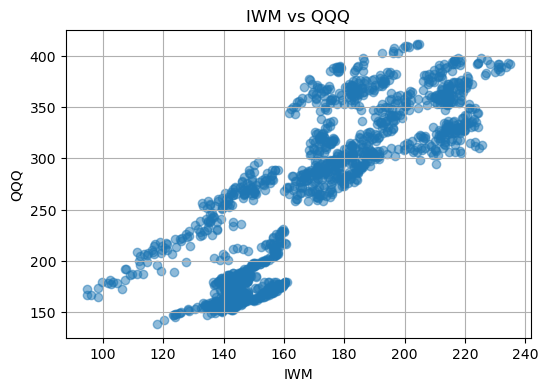

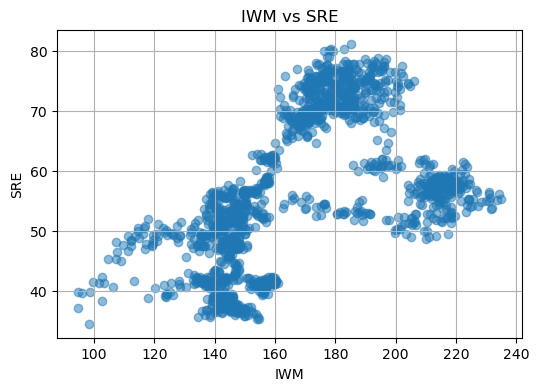

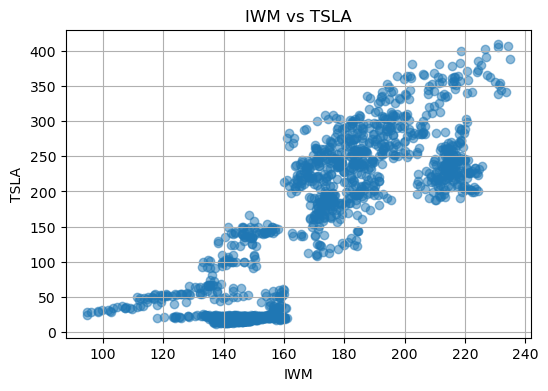

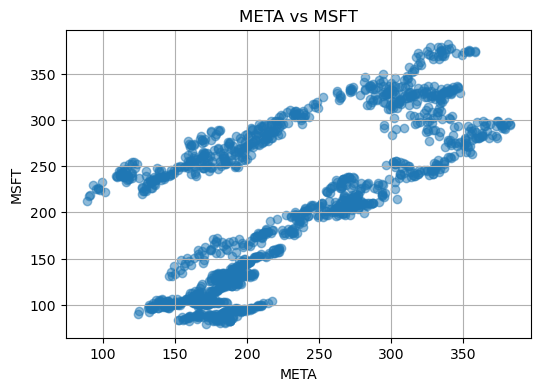

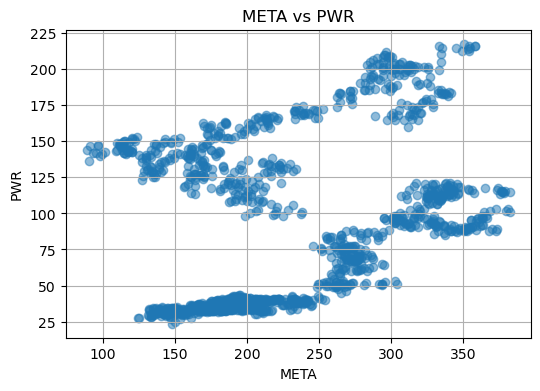

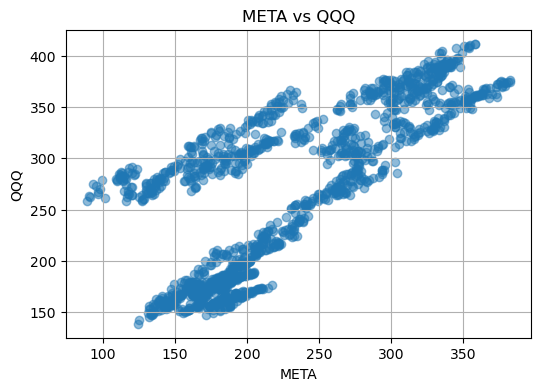

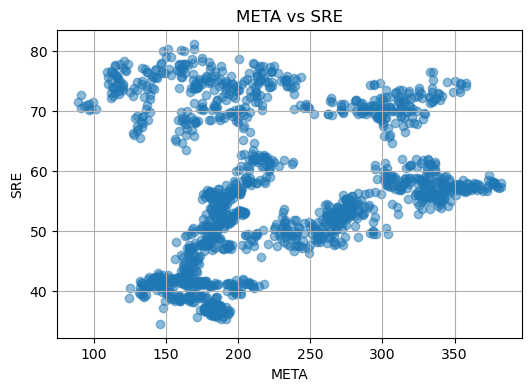

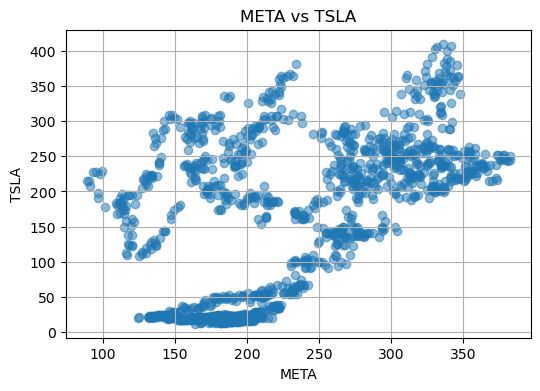

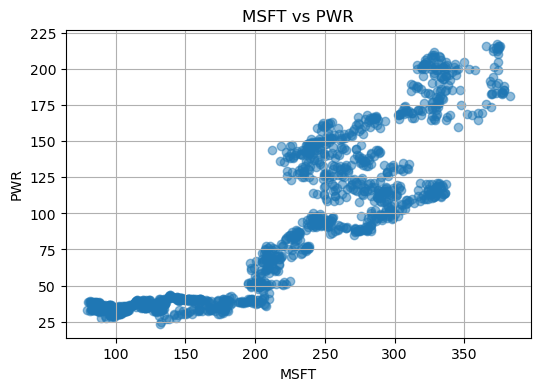

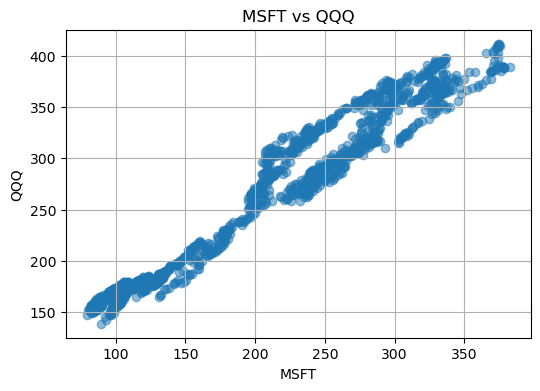

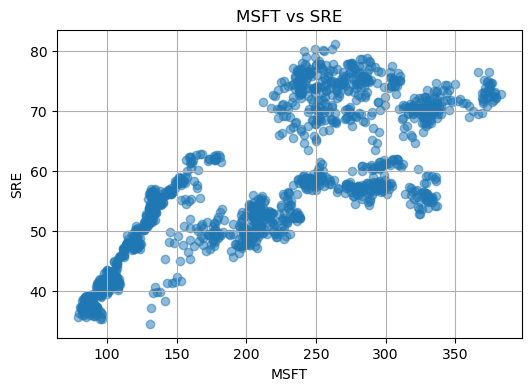

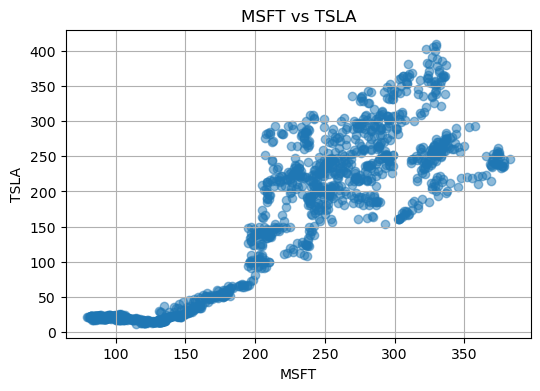

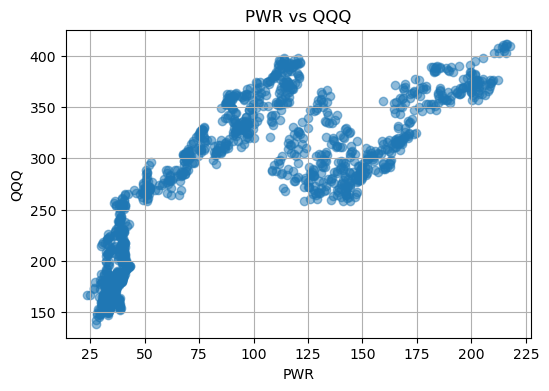

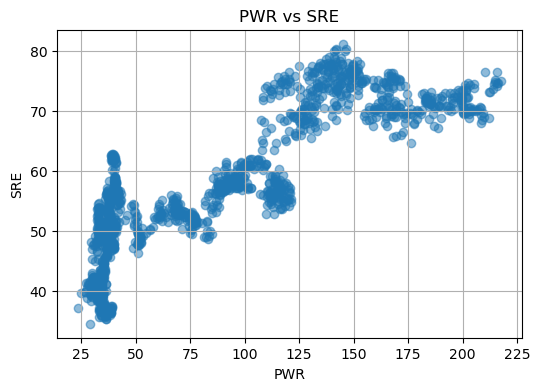

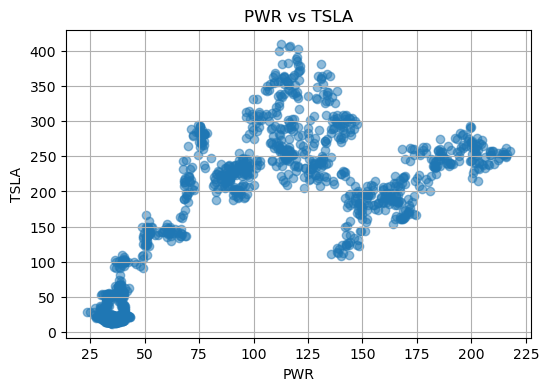

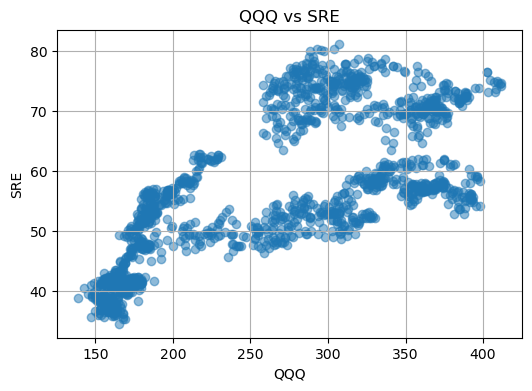

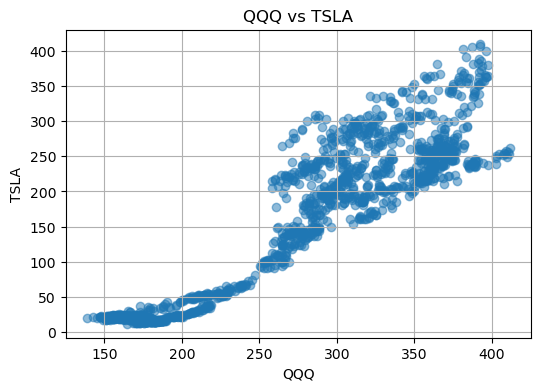

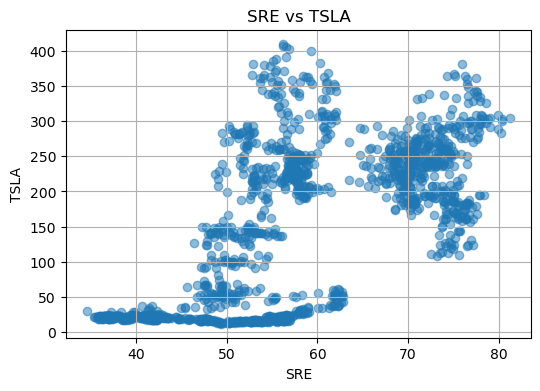

In [6]:
# Plotting
num_features = df.select_dtypes(include=[np.number]).columns

# Histograms for numerical features
for col in num_features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col].values, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

# Boxplots for numerical features
for col in num_features:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col].dropna().values)  # Ensure NaNs are dropped for boxplot
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
plt.imshow(df.corr(), cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(df.corr().columns)), df.corr().columns, rotation='vertical')
plt.yticks(range(len(df.corr().columns)), df.corr().columns)
plt.title('Correlation Matrix')
plt.show()

# Scatter plots for numerical features
for i, col1 in enumerate(num_features):
    for j, col2 in enumerate(num_features):
        if i < j:
            plt.figure(figsize=(6, 4))
            plt.scatter(df[col1], df[col2], alpha=0.5)
            plt.title(f'{col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.grid(True)
            plt.show()

In [7]:
len(df['SPY'])

1509

This section of the script focuses on dynamically creating visualizations for each numeric column in the dataset:

---

## Dynamic Visualization of Numeric Columns

### Identifying Numeric Columns
The script begins by identifying all numeric columns in the DataFrame, excluding the timestamp column (which is now the index):

```python
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
```

This step ensures that only relevant columns (i.e., those containing numeric data suitable for time series analysis) are considered for visualization.

### Preparing Subplots
The script dynamically creates a subplot for each numeric column:

```python
num_columns = len(numeric_columns)  # Calculating the number of numeric columns
fig, axs = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))  # Creating subplots

if num_columns == 1:
    axs = [axs]  # Handling the case where there is only one numeric column
```

This approach allows for flexibility in handling datasets with varying numbers of numeric columns, ensuring that each is given individual attention in the visualization process.

### Plotting Each Numeric Column
For each numeric column, a line plot is created:

```python
for i, col in enumerate(numeric_columns):
    df[col].plot(ax=axs[i], color='blue')  # Plotting the column
    axs[i].set_title(col)                  # Setting the title for each subplot
    axs[i].set_xlabel('Timestamp')         # Labeling the x-axis
    axs[i].set_ylabel('Value')             # Labeling the y-axis
```

This loop ensures that each numeric column in the DataFrame is visualized separately, providing a clear and detailed view of each time series.

### Visualization Output
- **Individual Plots for Each Numeric Column**: The script generates individual plots for each numeric column, making it easier to analyze each time series independently.
- **Customization**: Each subplot is customized with appropriate titles and axis labels, enhancing the clarity of the information presented.
- **Layout Adjustments**: The layout is adjusted to ensure that the plots are neatly organized and easily interpretable.

### Significance
This dynamic approach to visualization is particularly useful in datasets with multiple time series data columns. It allows for a comprehensive analysis, enabling the identification of unique characteristics and patterns in each time series.

---

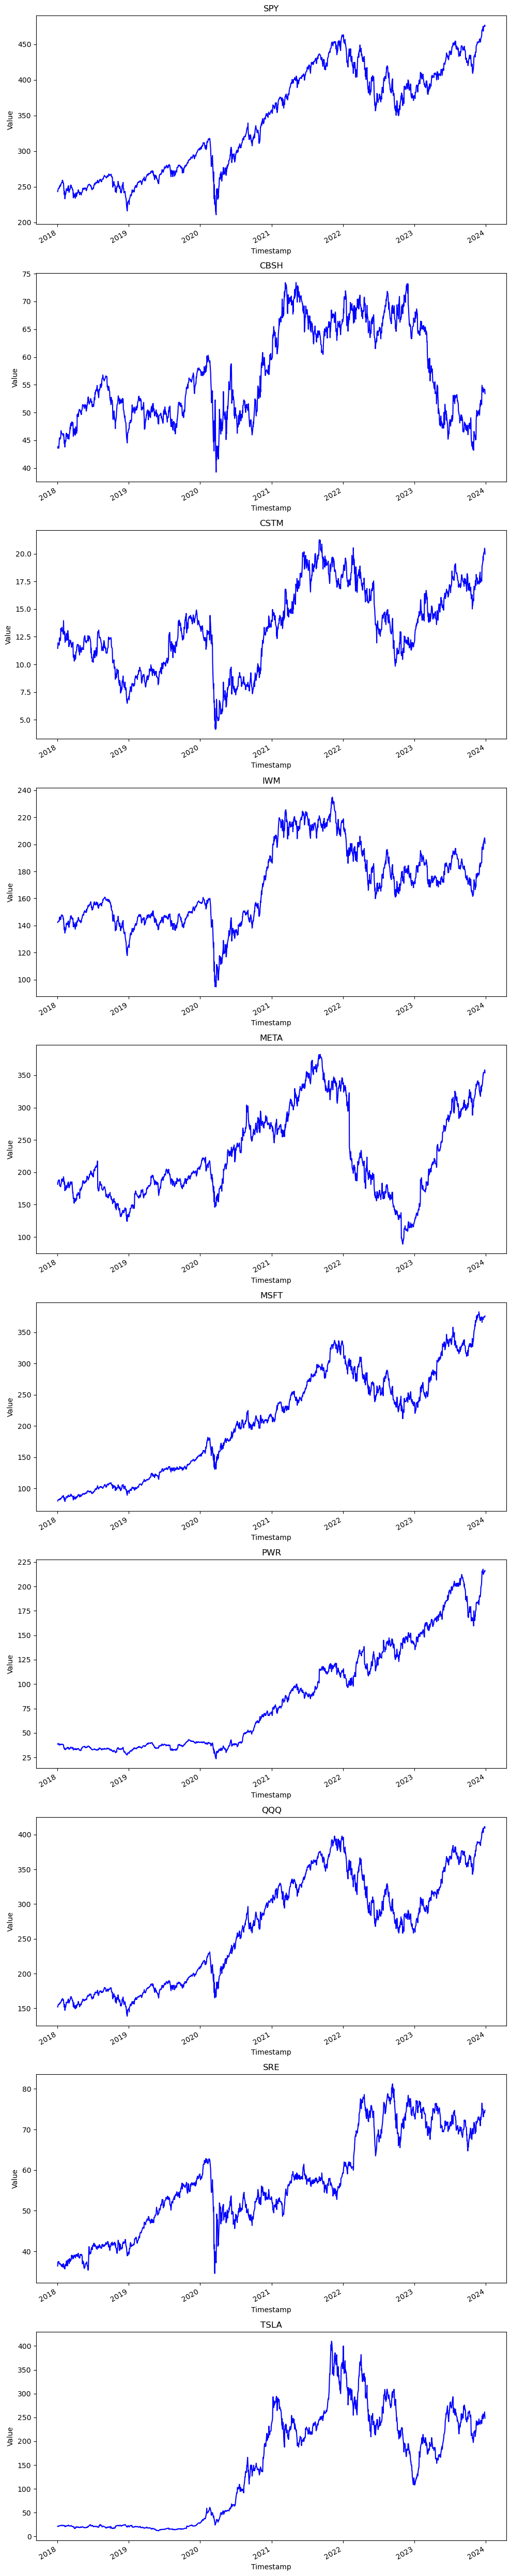

In [8]:
# Identifying numeric columns (excluding the timestamp column if it's there)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Number of numeric columns
num_columns = len(numeric_columns)

# Create the figure with dynamic subplots based on the number of numeric columns
fig, axs = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))

# Check if there's only one numeric column (to handle subplot indexing)
if num_columns == 1:
    axs = [axs]

# Loop through the numeric columns and create a plot for each
for i, col in enumerate(numeric_columns):
    df[col].plot(ax=axs[i], color='blue')
    axs[i].set_title(col)
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

This part of the script focuses on preparing for the model fitting and evaluation phase of the ARIMA model:

---

## Preparation for Model Fitting and Evaluation

### Extracting Column Names
The script starts by extracting the names of all columns in the DataFrame:

```python
variables = list(df.columns)
```

This step is essential if the DataFrame contains multiple columns of interest.

### Setting up Storage for Models and Errors
The script then initializes lists to store the models and various error metrics for each variable:

```python
models = []       # List to store the ARIMA models
rmse_multi = []   # List to store the Root Mean Square Errors (RMSE)
mae_multi = []    # List to store the Mean Absolute Errors (MAE)
ape_multi = []    # List to store the Absolute Percentage Errors (APE)
```

These lists will be used to store the results from the ARIMA models fitted to each variable in the DataFrame. This help for comparing the performance of models across different time series variables.

### Key Points

- **Model Storage**: `models` list will hold the ARIMA models created for each variable, allowing for easy access and comparison of different model configurations.
- **Error Metrics**: The `rmse_multi`, `mae_multi`, and `ape_multi` lists are crucial for evaluating and comparing the performance of the ARIMA models on different variables. These metrics will provide insights into the accuracy and reliability of the models.
    - **RMSE (Root Mean Square Error)**: Measures the model's prediction error.
    - **MAE (Mean Absolute Error)**: Evaluates the average magnitude of the errors in a set of predictions.
    - **APE (Absolute Percentage Error)**: Represents the error as a percentage, which can be particularly useful for understanding the relative size of the errors in terms of the actual values.

### Significance
This step is crucial for a dynamic and systematic approach to model fitting and evaluation. By organizing the storage of models and their corresponding error metrics, the script sets the stage for an in depth analysis of the ARIMA models' performance across different time series variables in the dataset.

---

In [9]:
# Get the column names of the DataFrame
variables = df.columns 
variables = list(df.columns)
variables

# Store models, predictions and errors
models = []  # List to store the models
rmse_multi = []  # List to store the root mean square errors (RMSE)
mae_multi = []  # List to store the mean absolute errors (MAE)
ape_multi = []  # List to store the absolute percentage errors for each variable


---

## ARIMA Model Fitting and Evaluation for Each Variable

### Iterating through Variables
The script iterates through each variable (column) in the DataFrame to fit an ARIMA model:

```python
for var in variables:
    ...
```

### Model Selection via Grid Search
- **Grid Search for (p, d, q) Values**: The script performs a grid search over possible combinations of (p, d, q) orders, fitting an ARIMA model for each combination.
- **Building the script to find these values**: Due to having multiple time series (more than 1 stock), every individual time series requires different p, d, and q values in order to best fit the model and ensure best accuracy. This is the only way I could find that subsequently served as a huge time saver, and is likely best practice when handling more than one time-series.
- **Selection Criterion**: The Akaike Information Criterion (AIC) is used to select the best model. A lower AIC value indicates a better model fit. This is used as the criteria focus on the forecasting and predictive power of the model

### Visualization of ACF and PACF
- **Autocorrelation and Partial Autocorrelation Plots**: For the best model, the script generates plots of the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF). These plots help in understanding the correlation structure of the time series.

### Residual Analysis
- **Stationarity Test of Residuals (ADF Test)**: The script uses the Augmented Dickey-Fuller (ADF) test to check if the residuals of the fitted model are stationary.
- **Autocorrelation Test of Residuals (Ljung-Box Test)**: The Ljung-Box test checks for the presence of autocorrelation in the residuals at different lags.

### Predictions and Error Calculation
- **Forecasting**: The script forecasts future values using the best ARIMA model and compares these forecasts with the actual values.
- **Error Metrics**: Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) are calculated to evaluate the prediction accuracy. Absolute Percentage Error (APE) is also computed for each forecasted value.

### Visualization of Predictions and Errors
- **Prediction Plot**: The script uses Plotly to create a dynamic plot showing the actual values, predicted values, and the confidence interval.
- **Error Plot**: A bar plot visualizes the Absolute Percentage Error for each forecasted point.

### Key Points
- **Dynamic Approach**: The script's ability to handle multiple variables in a dataset makes it versatile for different time series datasets.
- **Comprehensive Evaluation**: Each ARIMA model is thoroughly evaluated using statistical tests, error metrics, and visualizations, ensuring a robust analysis.

### Significance
This process is crucial for developing reliable ARIMA models for each variable in the dataset. By systematically selecting, fitting, and evaluating the models, the script ensures accurate and trustworthy forecasts.

---

Structure of The ARIMA Model For SPY: (2, 1, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                 1509
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4242.003
Date:                Mon, 04 Mar 2024   AIC                           8494.007
Time:                        19:25:56   BIC                           8520.599
Sample:                             0   HQIC                          8503.911
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7673      0.027    -65.975      0.000      -1.820      -1.715
ar.L2         -0.8878      0.025    -35.371      0.000      -0.937

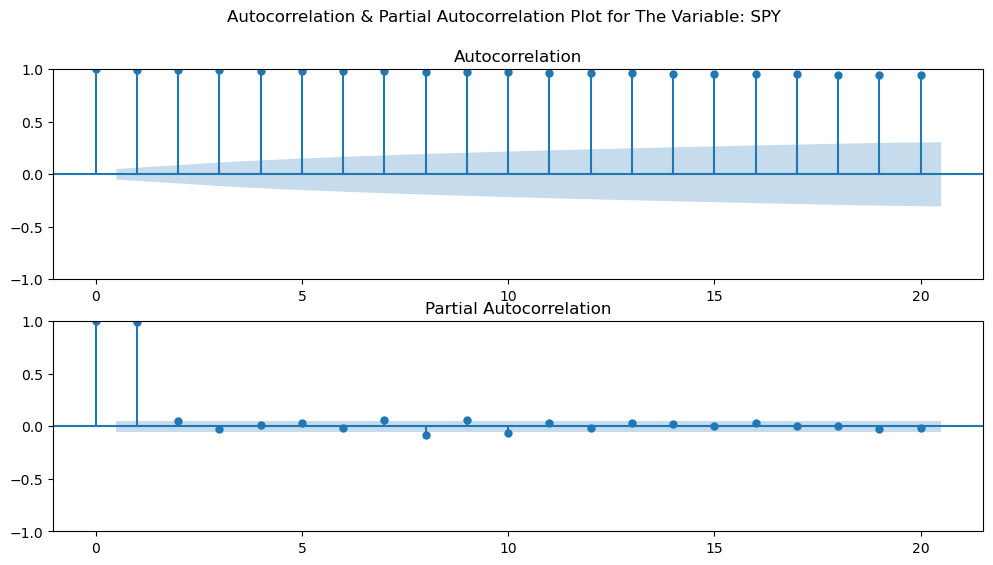



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -71.06596155287077
p-value: 0.0
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 0.8452943584039303
p-value: 0.9999208345871031
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=377.868465, expected=375.118713
predicted=374.463364, expected=378.014709
predicted=378.152613, expected=373.700256
predicted=374.016024, expected=382.270020
predicted=381.407304, expected=382.053314
predicted=382.415885, expected=384.732605
predicted=384.607692, expected=389.598602
predicted=388.878038, expected=391.017090
predicted=391.717759, expected=392.533997
predicted=391.658244, expected=391.814941
predicted=392.642987, expected=385.628937
predicted=385.444989, expected=382.821655
predicted=383.295336, expected=389.953278
predicted=389.051116, expected=394.632141
predicted=394.742984, expected=394.208557
predicted=394.

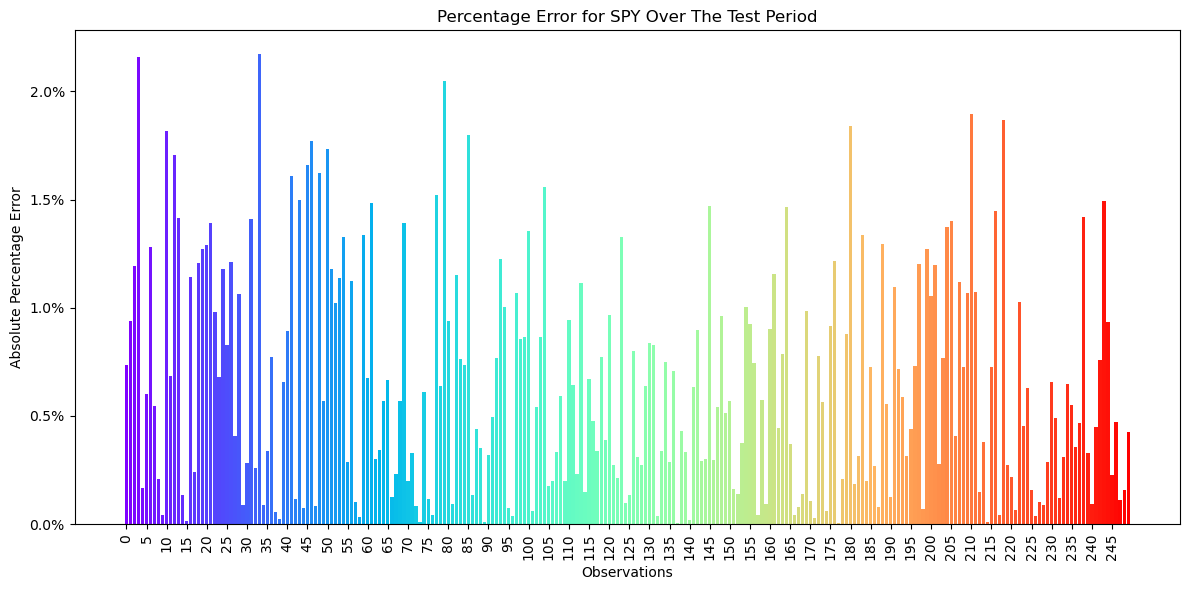

Structure of The ARIMA Model For CBSH: (2, 2, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   CBSH   No. Observations:                 1509
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2124.574
Date:                Mon, 04 Mar 2024   AIC                           4259.148
Time:                        19:28:21   BIC                           4285.737
Sample:                             0   HQIC                          4269.051
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0955      0.015    -71.386      0.000      -1.126      -1.065
ar.L2         -0.1136      0.015     -7.654      0.000      -0.14

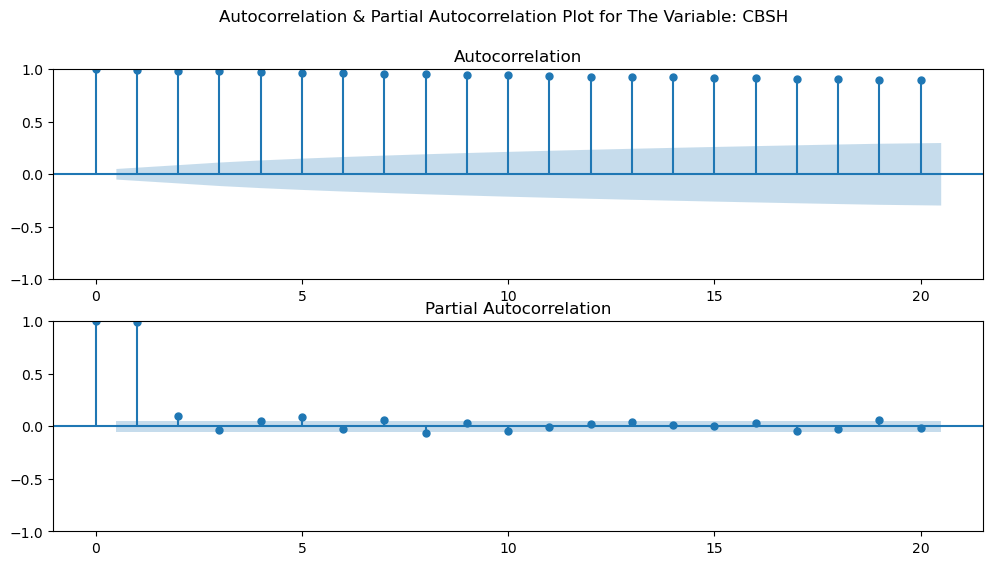



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -15.727725462714583
p-value: 1.3006502742961433e-28
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 98.67532451478716
p-value: 1.0030934529900877e-16
There is significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=66.773451, expected=66.259476
predicted=66.325125, expected=66.484879
predicted=66.493346, expected=66.308487
predicted=66.329701, expected=68.111732
predicted=67.961536, expected=66.994499
predicted=67.072933, expected=67.141510
predicted=67.234234, expected=67.631516
predicted=67.509913, expected=68.121521
predicted=68.166053, expected=68.660538
predicted=68.538465, expected=67.670723
predicted=67.870175, expected=65.181458
predicted=65.418256, expected=64.583633
predicted=64.768297, expected=64.260239
predicted=64.224061, expected=64.515038
predicted=64.599485, expected=64.701241
predicted=64.603132, exp

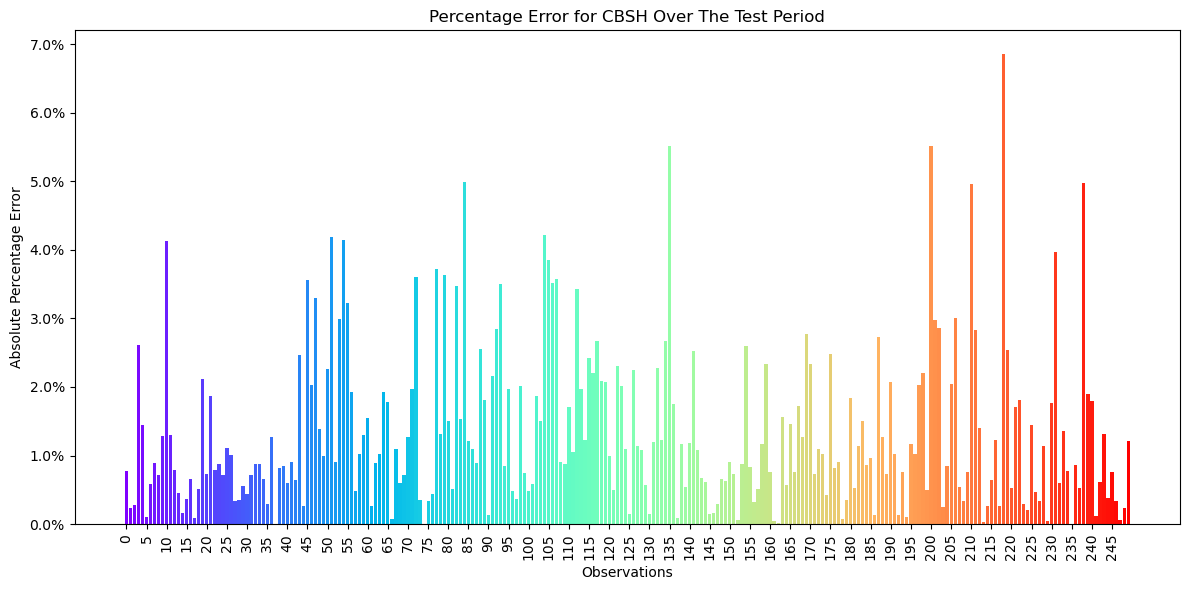

Structure of The ARIMA Model For CSTM: (2, 1, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   CSTM   No. Observations:                 1509
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -805.642
Date:                Mon, 04 Mar 2024   AIC                           1621.283
Time:                        19:32:03   BIC                           1647.876
Sample:                             0   HQIC                          1631.187
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5494      0.009    177.621      0.000       1.532       1.566
ar.L2         -0.9853      0.008   -118.398      0.000      -1.00

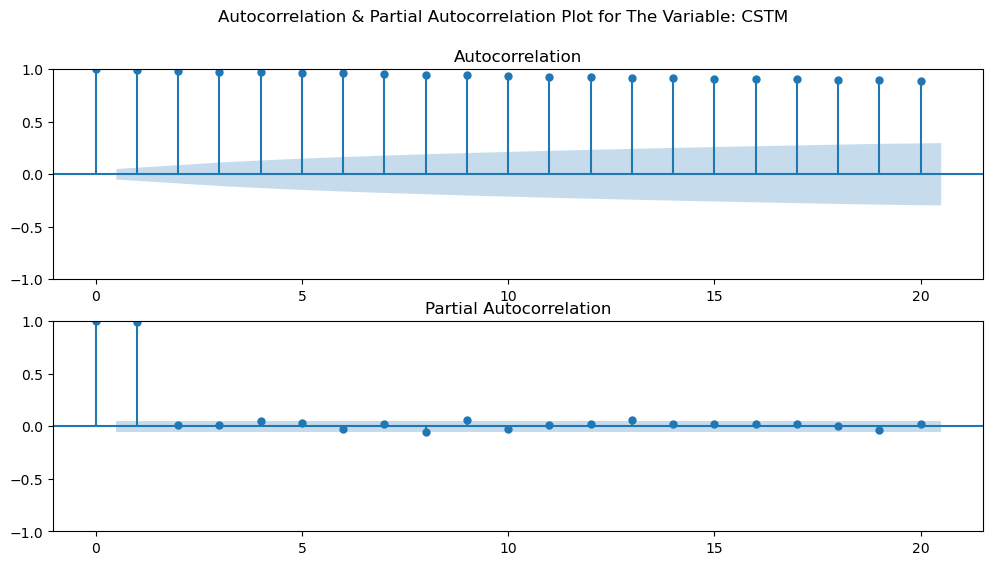



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -48.18610774735013
p-value: 0.0
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 8.845350254381417
p-value: 0.5468407241852972
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=11.831994, expected=12.120000
predicted=12.106434, expected=12.700000
predicted=12.673585, expected=12.820000
predicted=12.800006, expected=13.120000
predicted=13.089944, expected=13.200000
predicted=13.175965, expected=13.480000
predicted=13.447172, expected=13.430000
predicted=13.407671, expected=13.680000
predicted=13.647280, expected=13.550000
predicted=13.531116, expected=13.890000
predicted=13.855156, expected=14.100000
predicted=14.070037, expected=13.750000
predicted=13.735572, expected=14.080000
predicted=14.047144, expected=14.390000
predicted=14.359159, expected=14.320000
predicted=14.296928, expected=14.440000
predi

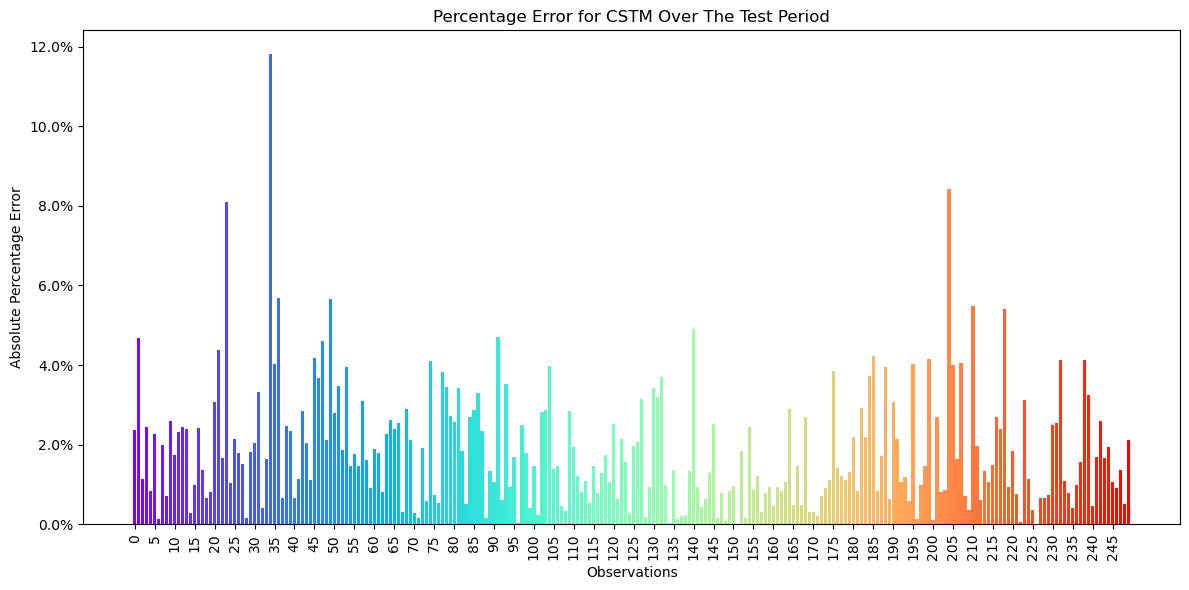

Structure of The ARIMA Model For IWM: (0, 1, 0)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    IWM   No. Observations:                 1509
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3549.009
Date:                Mon, 04 Mar 2024   AIC                           7100.018
Time:                        19:35:47   BIC                           7105.337
Sample:                             0   HQIC                          7101.999
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.4820      0.159     40.699      0.000       6.170       6.794
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):    

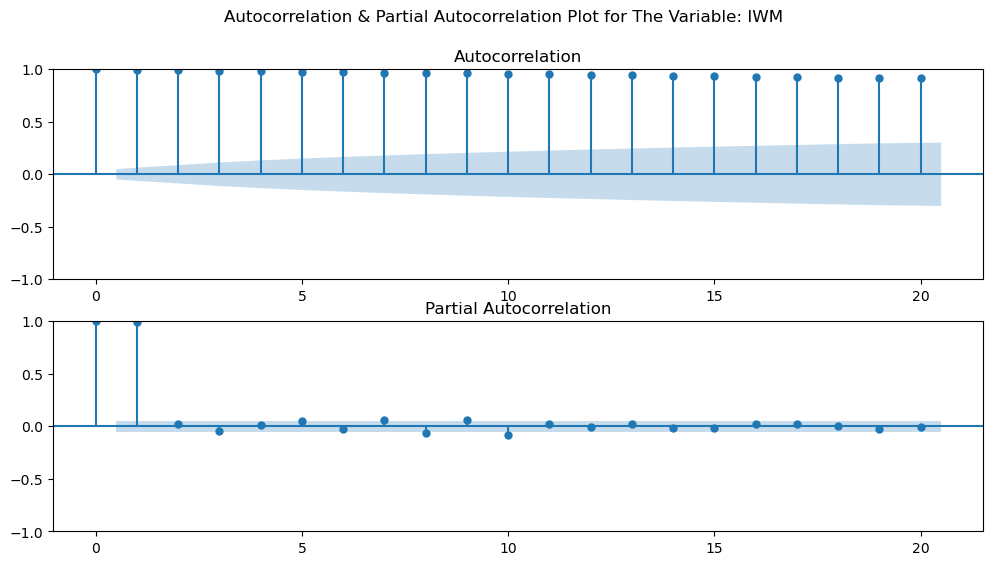



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -13.695443579276384
p-value: 1.3196339817189577e-25
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 3.3830933012698003
p-value: 0.9709195419135306
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=171.800095, expected=170.854172
predicted=170.854172, expected=172.982468
predicted=172.982468, expected=171.130066
predicted=171.130066, expected=174.972824
predicted=174.972824, expected=175.268402
predicted=175.268402, expected=177.859787
predicted=177.859787, expected=180.076736
predicted=180.076736, expected=183.101669
predicted=183.101669, expected=184.303772
predicted=184.303772, expected=184.077148
predicted=184.077148, expected=181.101486
predicted=181.101486, expected=179.367325
predicted=179.367325, expected=182.323273
predicted=182.323273, expected=184.579651
predicted=184.579651, expected=184.1

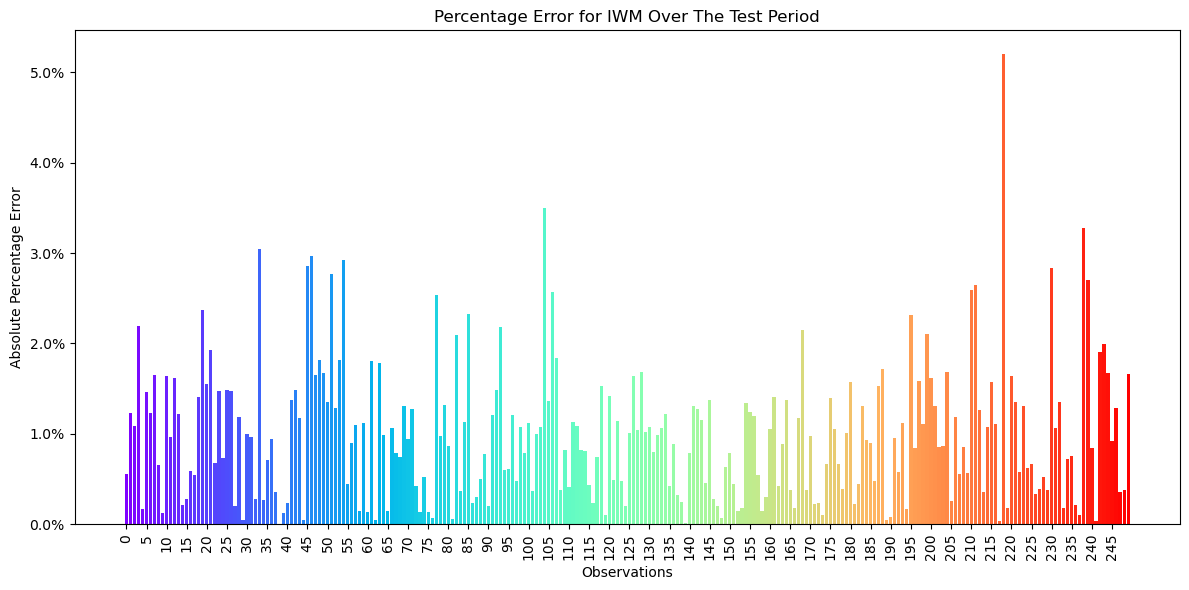

Structure of The ARIMA Model For META: (1, 1, 0)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   META   No. Observations:                 1509
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4791.858
Date:                Mon, 04 Mar 2024   AIC                           9587.716
Time:                        19:36:02   BIC                           9598.353
Sample:                             0   HQIC                          9591.677
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0400      0.026     -1.556      0.120      -0.090       0.010
sigma2        33.6957      0.294    114.499      0.000      33.11

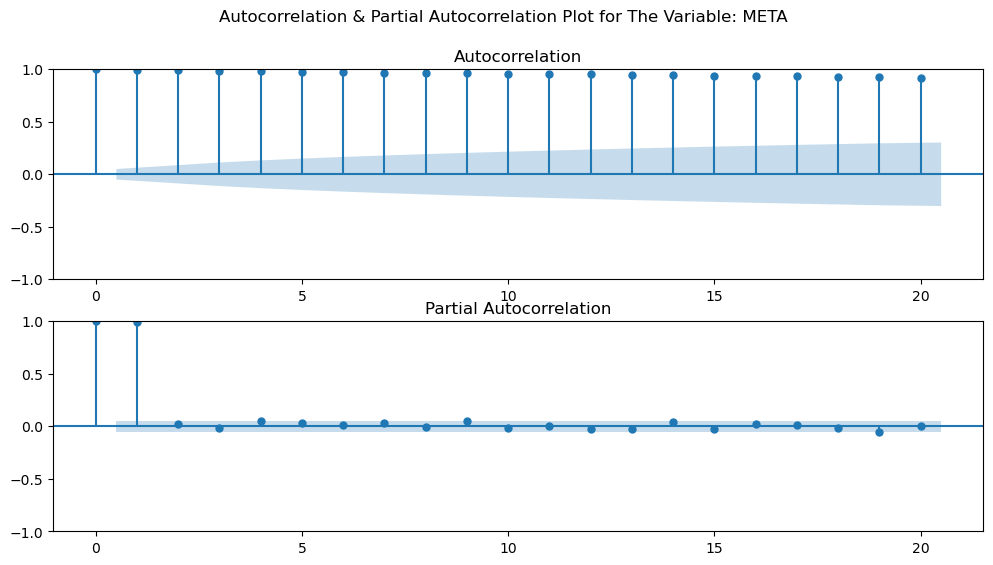



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -24.40276713386452
p-value: 0.0
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 7.065844386411898
p-value: 0.7192145643230173
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=120.335961, expected=124.739998
predicted=124.518116, expected=127.370003
predicted=127.238145, expected=126.940002
predicted=126.961568, expected=130.020004
predicted=129.865435, expected=129.470001
predicted=129.497618, expected=132.990005
predicted=132.813097, expected=132.889999
predicted=132.895024, expected=136.710007
predicted=136.518012, expected=136.979996
predicted=136.966437, expected=135.360001
predicted=135.441373, expected=133.020004
predicted=133.137328, expected=136.149994
predicted=135.992549, expected=139.369995
predicted=139.208813, expected=143.270004
predicted=143.075967, expected=143.139999
predicted=143.1

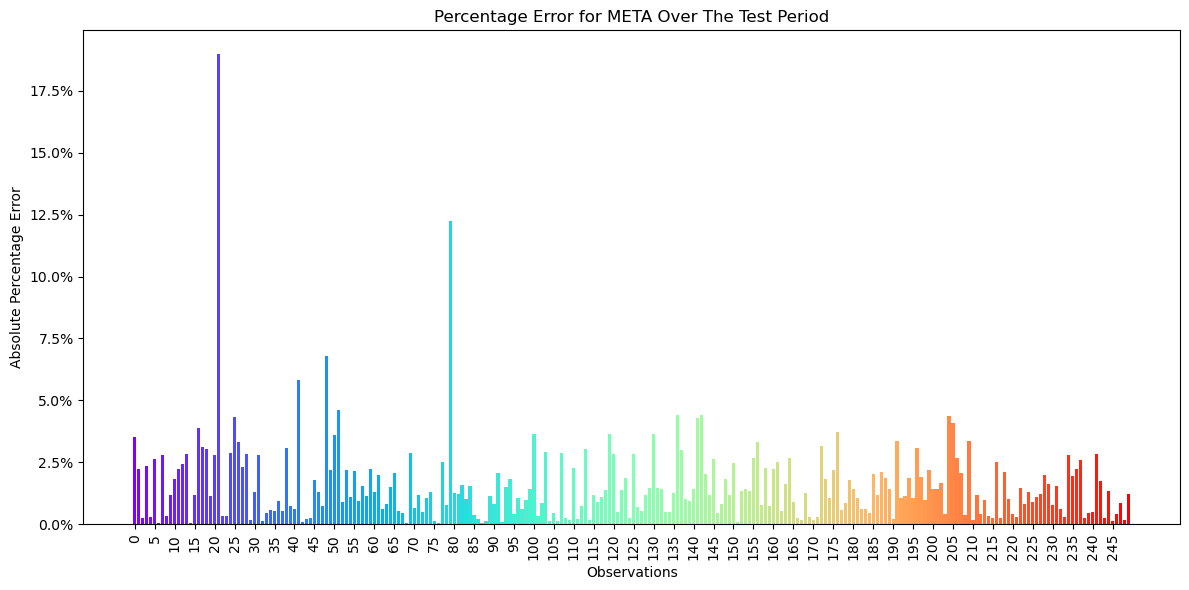

Structure of The ARIMA Model For MSFT: (2, 2, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 1509
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -4217.130
Date:                Mon, 04 Mar 2024   AIC                           8444.260
Time:                        19:36:21   BIC                           8470.849
Sample:                             0   HQIC                          8454.163
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9868      0.075    -13.101      0.000      -1.134      -0.839
ar.L2         -0.1224      0.017     -7.094      0.000      -0.15

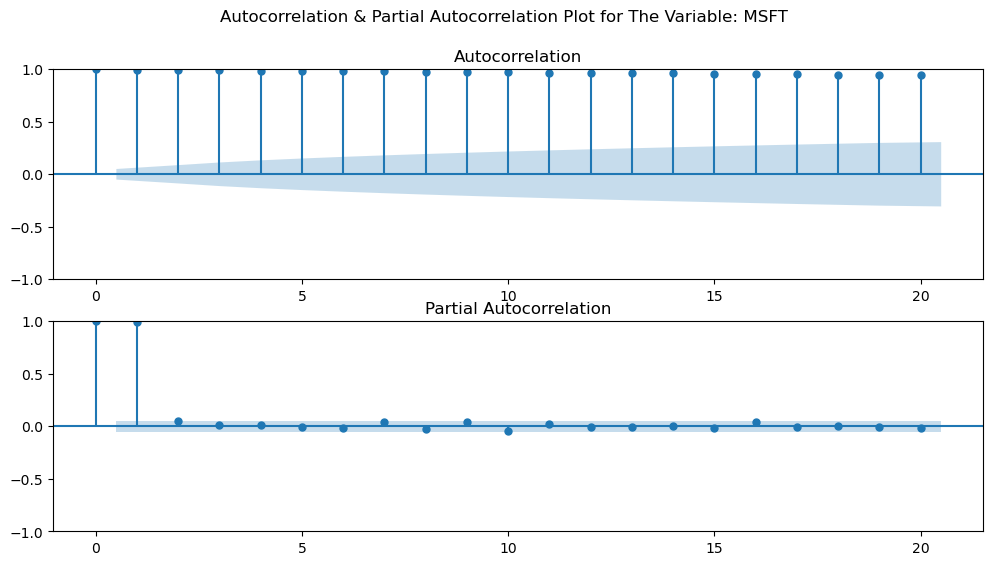



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -12.085500943214043
p-value: 2.182390227166176e-22
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 30.112889661814286
p-value: 0.0008209633055305948
There is significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=237.792401, expected=237.474335
predicted=237.864880, expected=227.086456
predicted=228.228984, expected=220.356110
predicted=221.525081, expected=222.953094
predicted=222.401424, expected=225.123840
predicted=225.106448, expected=226.838654
predicted=226.457673, expected=233.697830
predicted=232.856527, expected=236.413727
predicted=235.934758, expected=237.127411
predicted=237.037689, expected=238.237579
predicted=238.388807, expected=233.737457
predicted=234.254205, expected=229.891571
predicted=230.311073, expected=238.108719
predicted=237.400711, expected=240.447968
predicted=239.986709, expected=239.91

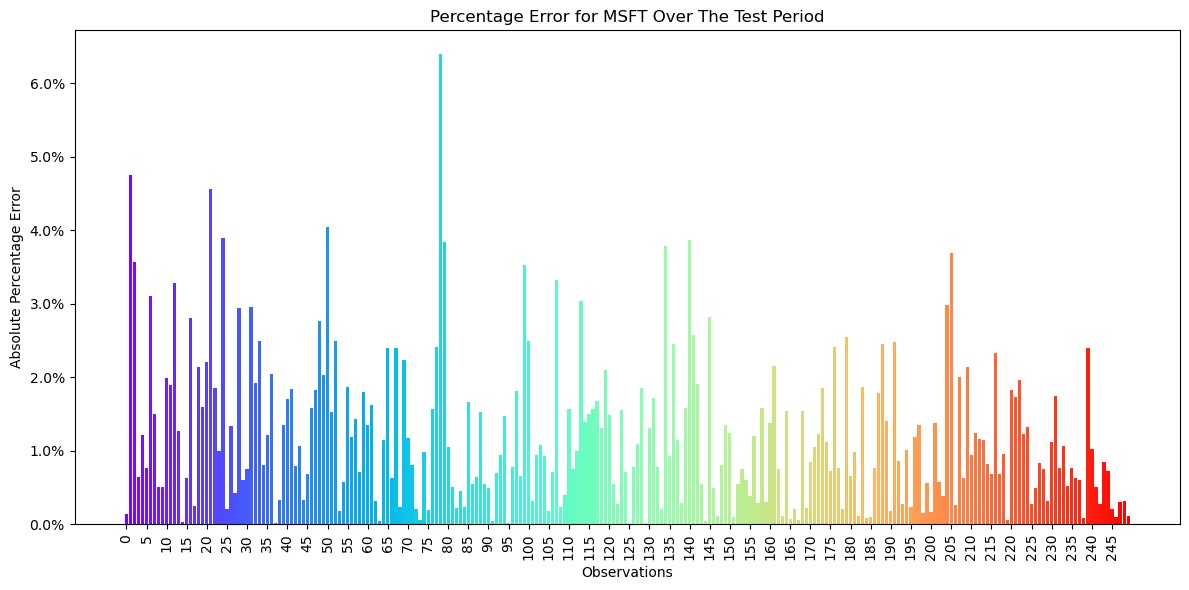

Structure of The ARIMA Model For PWR: (2, 1, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    PWR   No. Observations:                 1509
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3179.747
Date:                Mon, 04 Mar 2024   AIC                           6369.495
Time:                        19:41:10   BIC                           6396.087
Sample:                             0   HQIC                          6379.399
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7686      0.054     32.866      0.000       1.663       1.874
ar.L2         -0.7978      0.053    -15.153      0.000      -0.901

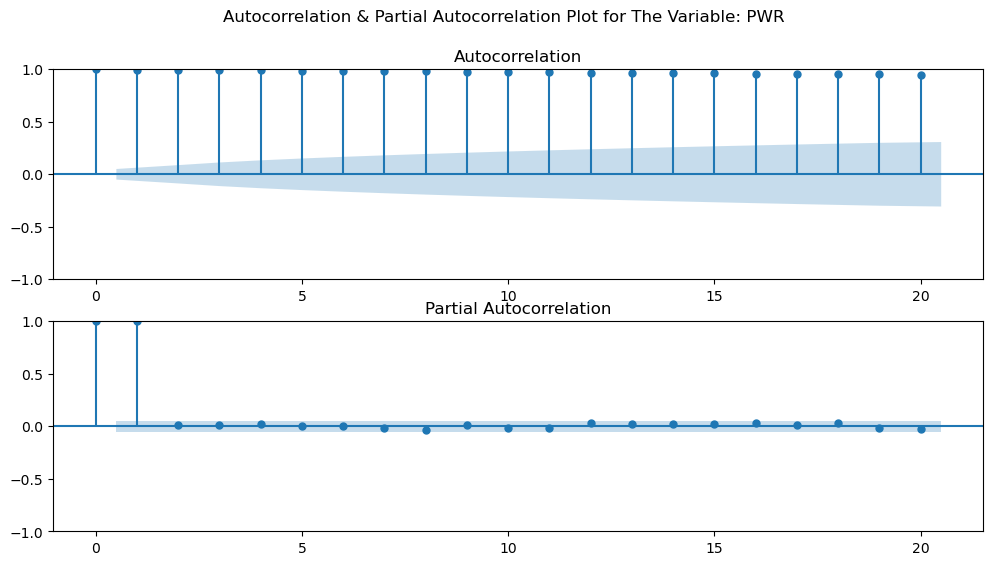



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -43.28759614296719
p-value: 0.0
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 1.386291053495559
p-value: 0.9992479705990062
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=142.204125, expected=140.364090
predicted=140.179704, expected=138.307709
predicted=138.181867, expected=135.332916
predicted=135.302651, expected=138.876694
predicted=138.742699, expected=138.397552
predicted=138.290242, expected=139.266022
predicted=139.145671, expected=140.443954
predicted=140.300196, expected=147.551498
predicted=147.165455, expected=148.240280
predicted=147.889398, expected=148.010712
predicted=147.719111, expected=144.047653
predicted=143.730327, expected=143.239075
predicted=143.189333, expected=145.984268
predicted=146.013635, expected=149.288467
predicted=149.287891, expected=151.245026
predicted=151.4

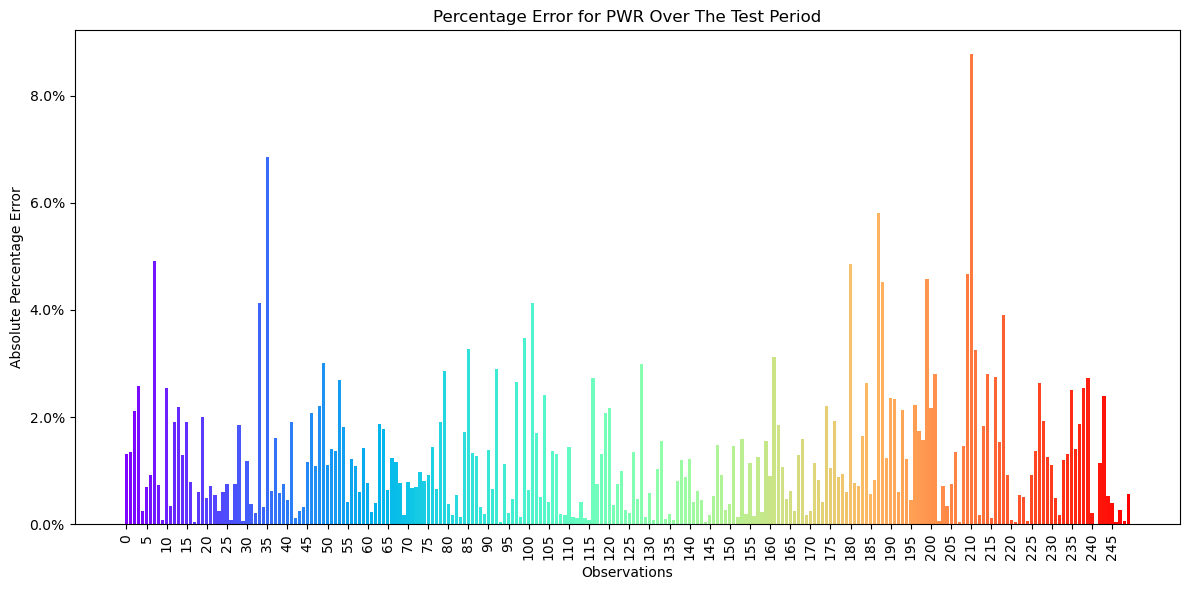

Structure of The ARIMA Model For QQQ: (2, 2, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    QQQ   No. Observations:                 1509
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -4254.376
Date:                Mon, 04 Mar 2024   AIC                           8518.752
Time:                        20:16:02   BIC                           8545.342
Sample:                             0   HQIC                          8528.655
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0165      0.044    -23.365      0.000      -1.102      -0.931
ar.L2         -0.0912      0.018     -4.975      0.000      -0.127

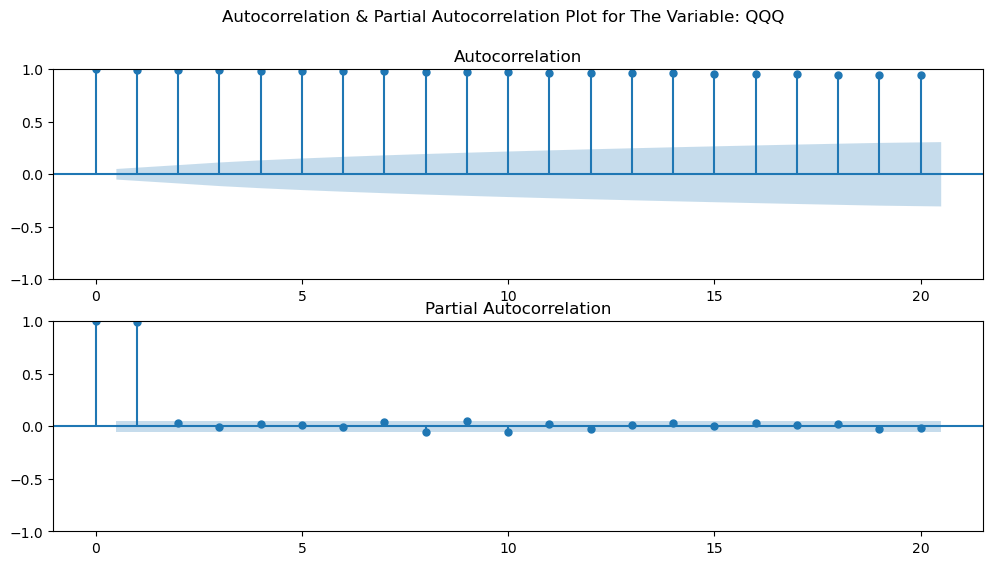



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -9.235851183221204
p-value: 1.6313238054407573e-15
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 70.74787063403636
p-value: 3.178953209579855e-11
There is significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=264.169659, expected=262.665192
predicted=262.861643, expected=263.916504
predicted=263.572582, expected=259.785095
predicted=260.069909, expected=266.955566
predicted=266.254513, expected=268.683594
predicted=268.149830, expected=270.957886
predicted=270.888219, expected=275.645477
predicted=274.916798, expected=277.135162
predicted=277.094834, expected=279.041992
predicted=278.732411, expected=279.608093
predicted=279.644936, expected=275.973236
predicted=276.207846, expected=273.261963
predicted=273.664349, expected=280.740295
predicted=279.977800, expected=286.977203
predicted=286.366142, expected=286.391

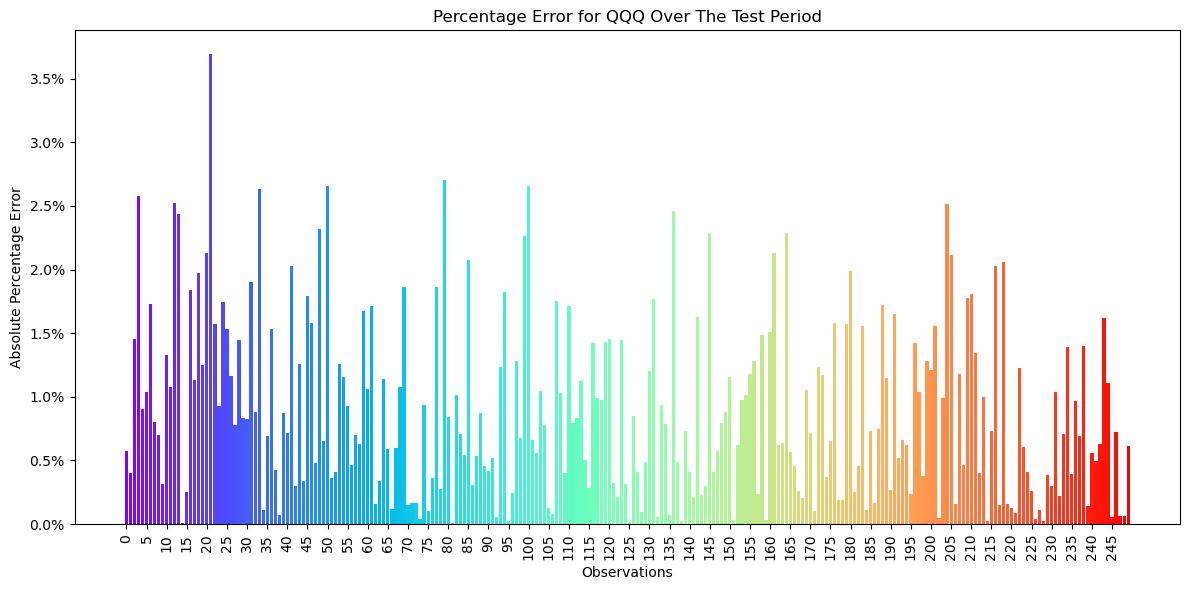

Structure of The ARIMA Model For SRE: (2, 1, 2)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    SRE   No. Observations:                 1509
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1977.604
Date:                Mon, 04 Mar 2024   AIC                           3965.209
Time:                        20:26:11   BIC                           3991.801
Sample:                             0   HQIC                          3975.113
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8333      0.099     -8.428      0.000      -1.027      -0.640
ar.L2         -0.7924      0.075    -10.551      0.000      -0.940

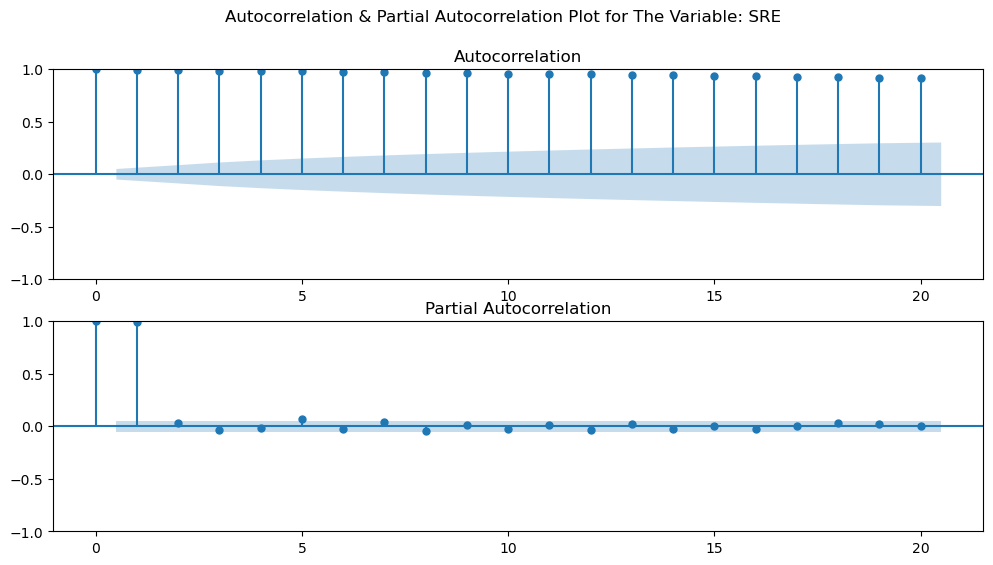



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -14.698332687563504
p-value: 2.9738728244155204e-27
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 4.606979478589313
p-value: 0.9158407964525603
There is no significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=73.540685, expected=73.158539
predicted=73.190979, expected=73.791542
predicted=73.738012, expected=72.573112
predicted=72.663183, expected=73.553574
predicted=73.437485, expected=74.786285
predicted=74.757670, expected=74.967148
predicted=75.092238, expected=77.132721
predicted=77.001955, expected=76.594894
predicted=76.727144, expected=76.547310
predicted=76.540133, expected=76.994705
predicted=76.900655, expected=74.576866
predicted=74.786349, expected=74.143753
predicted=74.001536, expected=75.195610
predicted=75.061438, expected=75.552567
predicted=75.727046, expected=75.733429
predicted=75.703980, expe

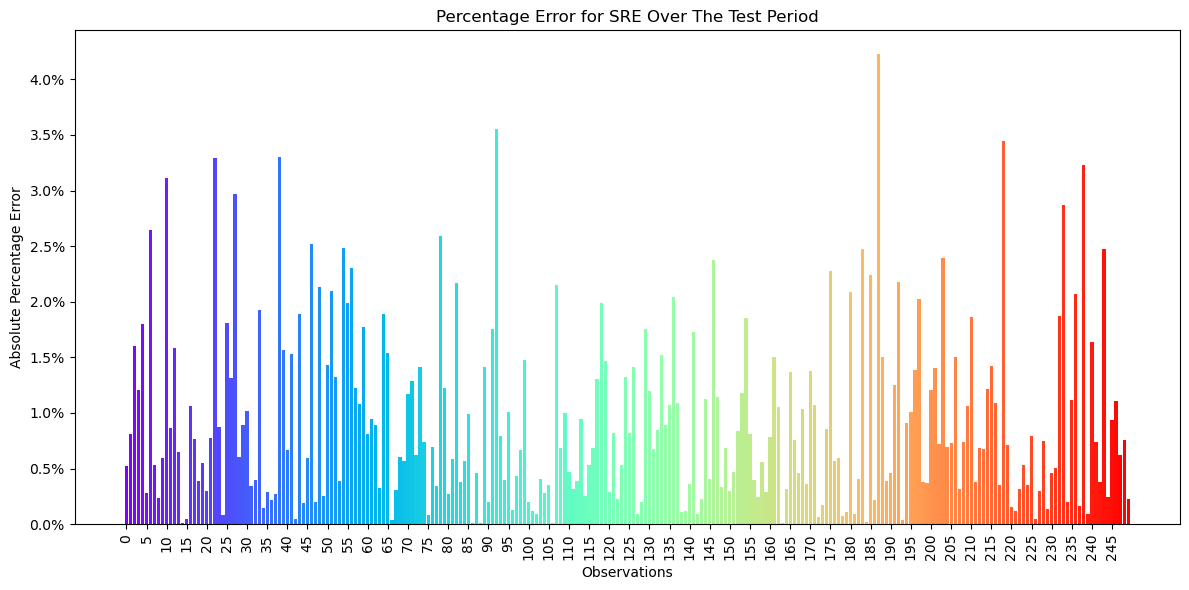

Structure of The ARIMA Model For TSLA: (0, 1, 0)


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1509
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5072.140
Date:                Mon, 04 Mar 2024   AIC                          10146.279
Time:                        20:31:40   BIC                          10151.598
Sample:                             0   HQIC                         10148.260
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        48.8678      0.842     58.045      0.000      47.218      50.518
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):   

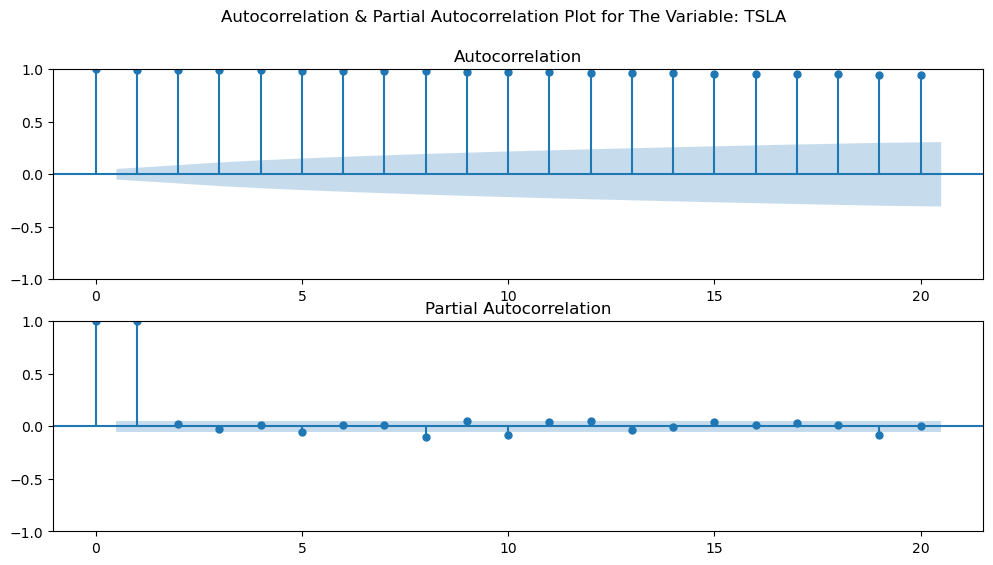



Test of if the Residuals Are Stationary Using the ADF Test:
ADF Statistic: -7.361207250281046
p-value: 9.489980403979296e-11
The residuals are stationary.


Test of if No Autocorrelation Using the Ljung-Box Test:
Ljung-Box Statistic: 36.094894665684585
p-value: 8.10729744598105e-05
There is significant autocorrelation in the residuals.


Prediction vs Observed Values:
predicted=123.180000, expected=108.099998
predicted=108.099998, expected=113.639999
predicted=113.639999, expected=110.339996
predicted=110.339996, expected=113.059998
predicted=113.059998, expected=119.769997
predicted=119.769997, expected=118.849998
predicted=118.849998, expected=123.220001
predicted=123.220001, expected=123.559998
predicted=123.559998, expected=122.400002
predicted=122.400002, expected=131.490005
predicted=131.490005, expected=128.779999
predicted=128.779999, expected=127.169998
predicted=127.169998, expected=133.419998
predicted=133.419998, expected=143.750000
predicted=143.750000, expected=143.8899

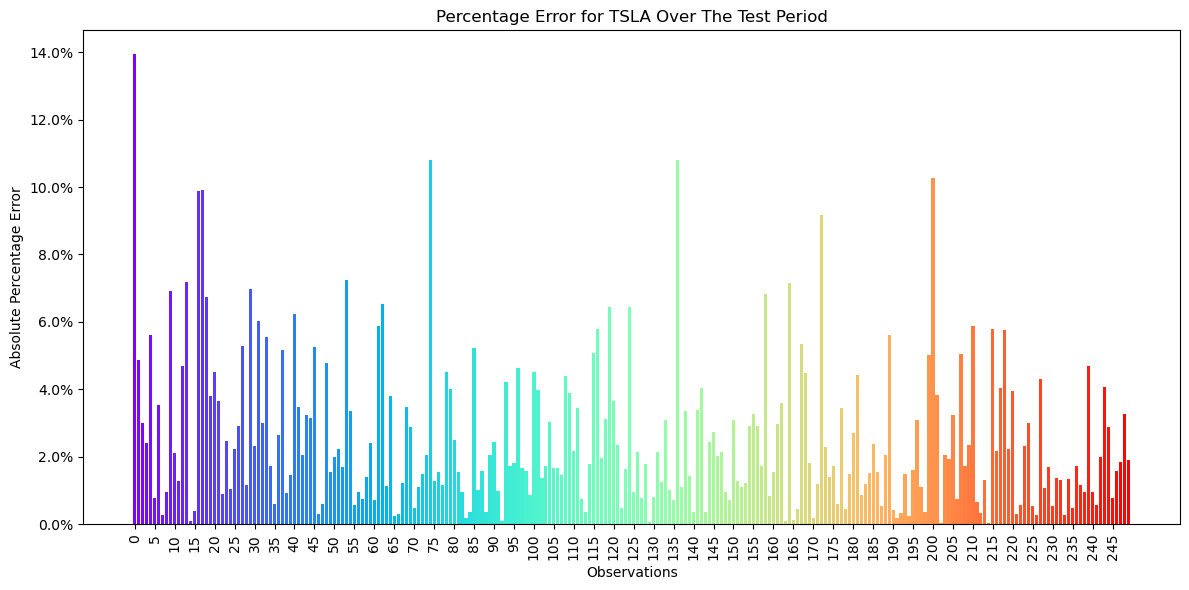

In [10]:
# Creating a dictionary to store residuals for each variable
residuals_dict = {}

# Iterating through all variables to fit an ARIMA model for each
for var in variables:
    best_aic = np.inf  # Variable to store the best AIC value
    best_order = None  # Variable to store the best (p, d, q) order
    best_model = None  # Variable to store the best ARIMA model
    best_model_fit = None  # Variable to store the fit of the best model
    
    # Grid search for p, d, q values
    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    # Fit an ARIMA model with the current (p, d, q) order
                    temp_model = ARIMA(df[var].dropna(), order=(p, d, q))
                    temp_model_fit = temp_model.fit()
                    temp_aic = temp_model_fit.aic

                    # Update the best model if the current AIC is better
                    if temp_aic < best_aic:
                        best_aic = temp_aic
                        best_order = (p, d, q)
                        best_model = temp_model
                        best_model_fit = temp_model_fit  # Save the fit model
                except:
                    continue

    models.append(best_model)
    
    # Save the residuals for the current variable
    residuals_dict[var] = best_model_fit.resid

    # Print the structure of the best ARIMA model for the current variable
    print(f"\033[1mStructure of The ARIMA Model For {var}: {best_order}\033[0m")
    print("\n")

    # Print the summary of the best ARIMA model
    print(f"\033[1mModel Summary:\033[0m")
    print(best_model_fit.summary())
    print("\n")

    # Plotting the ACF and PACF for the best model
    print("\033[1mPlotting the ACF and PACF:\033[0m")
    plt.figure(figsize=(12, 6))
    plt.suptitle('Autocorrelation & Partial Autocorrelation Plot for The Variable: ' + var)

    plt.subplot(211)
    plot_acf(df[var].dropna(), lags=20, ax=plt.gca())

    plt.subplot(212)
    plot_pacf(df[var].dropna(), lags=20, ax=plt.gca())

    plt.show()
    print("\n")

    # Test for stationarity of residuals using ADF test
    print("\033[1mTest of if the Residuals Are Stationary Using the ADF Test:\033[0m")
    adf_result = adfuller(best_model_fit.resid)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print("The residuals are stationary.")
    else:
        print("The residuals are not stationary.")
    print("\n")

    # Test for autocorrelation in residuals using Ljung-Box test
    print("\033[1mTest of if No Autocorrelation Using the Ljung-Box Test:\033[0m")
    lb_test = acorr_ljungbox(best_model_fit.resid, lags=[10], return_df=True)
    print(f"Ljung-Box Statistic: {lb_test['lb_stat'].values[0]}")
    print(f"p-value: {lb_test['lb_pvalue'].values[0]}")
    if lb_test['lb_pvalue'].values[0] > 0.05:
        print("There is no significant autocorrelation in the residuals.")
    else:
        print("There is significant autocorrelation in the residuals.")
    print("\n")

    # Predictions
    print("\033[1mPrediction vs Observed Values:\033[0m")
    history = [x for x in df[var].dropna()[:-250]]  # Training data points
    test = [x for x in df[var].dropna()[1259:]]  # Test data points
    predictions = []
    ape = []  # List to store the absolute percentage errors for the current variable
    lower_ci, upper_ci = [], []  # lists to store lower and upper confidence intervals

    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.get_prediction(start=len(history), dynamic=False)  # perform forecast
        pred_df = output.summary_frame(alpha=0.05)  # Summary dataframe
        yhat = pred_df['mean'].values[0]  # Predicted value
        lower = pred_df['mean_ci_lower'].values[0]  # lower bound of confidence interval
        upper = pred_df['mean_ci_upper'].values[0]  # upper bound of confidence interval
        predictions.append(yhat)
        lower_ci.append(lower)
        upper_ci.append(upper)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        ape.append(abs((obs - yhat) / obs) * 100)  # Calculate the APE and add it to the list
        
    ape_multi.append(ape)  # Store the list of APEs for the current variable

    # Calculate the RMSE, MAE, and APE
    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    rmse_multi.append(rmse)
    mae_multi.append(mae)

    # Print prediction performance and results for the current variable
    print("\n")
    print("\033[1mPrediction Performance & Results:\033[0m")
    print(f"Item: {var}")
    print(f"Best ARIMA Structure is: {best_order}")
    print(f"Best AIC found is: {best_aic}")
    print(f"The RMSE of the predictions is: {rmse}")
    print(f"Mean Absolute Percentage Error of the prediction is: {np.mean(ape)}%")

    # Plotting the predictions
    trace1 = go.Scatter(
        x=list(range(len(test))),
        y=test,
        mode='lines',
        name='Test Data',
        line=dict(color='skyblue', width=2.5)
    )

    # Create a trace for predicted data
    trace2 = go.Scatter(
        x=list(range(len(predictions))),
        y=predictions,
        mode='lines',
        name='Predicted Data',
        line=dict(color='red', width=2.5, dash='dash')
    )

    # Create a trace for the confidence interval
    trace3 = go.Scatter(
        x=list(range(len(predictions))) + list(range(len(predictions)))[::-1],  # x, then x reversed
        y=upper_ci + lower_ci[::-1],  # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(255, 105, 180, 0.3)',  # lightpink with alpha 0.3
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        name='95% Confidence Interval',
        showlegend=False
    )

    data = [trace1, trace2, trace3]

    layout = go.Layout(
        title=dict(
            text=f'{var} vs Predicted {var} with Confidence Interval',
            x=0.5,
            font=dict(
                size=20
            )
        ),
        xaxis=dict(
            title='Time',
            titlefont=dict(
                size=15
            )
        ),
        yaxis=dict(
            title=var,
            titlefont=dict(
                size=15
            )
        ),
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()
    
    # Reducing the number of x-ticks by only showing every nth label
    n = 5  # Show every 5th label

    # Plotting absolute percentage errors for the current variable over the test period
    plt.figure(figsize=(12, 6))

    # Generate a colormap for the errors
    colors = cm.rainbow(np.linspace(0, 1, len(ape)))

    # Create the bar plot
    plt.bar(range(len(ape)), ape, color=colors)

    plt.title(f'Percentage Error for {var} Over The Test Period 2023')
    plt.xlabel('Observations')
    plt.ylabel('Absolute Percentage Error')

    # Formatting the y-axis to display as percentages
    fmt = '{x:,.1f}%'
    tick = mtick.StrMethodFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(tick)
    
    # Rotate the x-axis labels to make them more readable
    plt.xticks(rotation=90)

    # Ensuring that x-axis labels are integers
    #xticks = np.arange(len(ape))
   # plt.xticks(xticks, xticks.astype(int))
    
    # Set x-ticks to only display every nth label
    xticks = np.arange(0, len(ape), n)
    plt.xticks(xticks, xticks.astype(int))
    
    plt.tight_layout()  # Adjust the padding between and around subplots.

    plt.show()


This part of the script is focused on exporting the residuals of each ARIMA model to Excel files:

---

## Exporting Model Residuals to Excel

### Process Overview
Upon completing the ARIMA model fitting and evaluation for each variable, the script exports the residuals of these models to individual Excel files. These files can be used for further analysis of the residuals. 

### Code Explanation
```python
for var, residuals in residuals_dict.items():
    ...
```

- **Iterating Through Residuals**: The script iterates through a dictionary `residuals_dict`, which  contain the residuals of the ARIMA models keyed by variable name.
- **Creating DataFrame for Residuals**: For each variable, a new DataFrame is created with the residuals.
- **Exporting to Excel**: The residuals DataFrame is then saved to an Excel file. The filename is based on the variable name, making it easy to identify the corresponding model's residuals.

### Key Points
- **File Naming Convention**: The use of the variable name in the filename (`"{var}_residuals.xlsx"`) ensures clarity and helps in maintaining an organized workspace, especially when dealing with multiple variables.

### Example Output
- For each variable in the dataset, an Excel file is generated, named appropriately (e.g., `SPY_residuals.xlsx`), containing the residuals from the ARIMA model.
- The script also prints a confirmation message for each file created, like `Residuals for SPY saved to SPY_residuals.xlsx`.

### Significance
Exporting the residuals match the request to have residuals saved for later use. Other types of regression can be performed, so this is done in the possibility of this.

---

In [11]:
# Export residuals to Excel files after completing the loop for all variables
for var, residuals in residuals_dict.items():
    residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
    residuals_df.to_excel(f"{var}_residuals.xlsx", index=False)
    print(f"Residuals for {var} saved to {var}_residuals.xlsx")

Residuals for SPY saved to SPY_residuals.xlsx
Residuals for CBSH saved to CBSH_residuals.xlsx
Residuals for CSTM saved to CSTM_residuals.xlsx


Residuals for IWM saved to IWM_residuals.xlsx
Residuals for META saved to META_residuals.xlsx
Residuals for MSFT saved to MSFT_residuals.xlsx
Residuals for PWR saved to PWR_residuals.xlsx
Residuals for QQQ saved to QQQ_residuals.xlsx
Residuals for SRE saved to SRE_residuals.xlsx
Residuals for TSLA saved to TSLA_residuals.xlsx


---

## Conclusion // Final Thoughts

### This ARIMA model is an extremely powerful tool that can be used to forecast stock data with high degree of accuracy. 
The script begins by importing various Python libraries necessary for time series analysis and model development:
- **Seasonality**: This issue seems to be possible for stocks and certain time series data. This could be something to consider in the future if I wanted to attempt to get even more accurate predictions.
- **Unpredictability**: Forecasting stock data alwyas contains a margin of error, and even to some extent some guessing. This model (in its current form) is likely not going to be the most useful way to invest in the stock market. However, it does give me some confidence that my choices would be worth picking.
- **Autocorrelation**: This is something that is technically present in some stocks' data such as Microsoft. In two observations in the Microsoft ARIMA, the Margin of Error jumps to 12.5% and 17.5%, I am not completely sure what this is, or even why. However it is possible that autocorrelation is present elsewhere that the model did not pick up? This does not necessarily mean that the presence of autocorrelation is a bad thing. There was also some autocorrelation for QQQ, Telsa, and Meta as well, however it was not significant enough to be a major problem in forecasting accuracy. I wonder if the high jump in forecasting percentage for single observations could be influencing this.
- **Replicability**: The benefit to this model is that it can be used over and over again, and with some extra work could even forecast information into the next year (2024). This was not originally apart of the goal and purpose of this model, so it will not be included in this.
- **Ease of Use**: ARIMA is not very user friendly, and requires more statistical understanding than originally thought. Having worked with this model and fought with it to get it to work correctly did not make me feel very confident after all was said and done. 
- **Learning Experiences**: Having such a difficult model to learn created a hyper-organized setting in which I was able to operate. I have never needed to organize my thoughts, processes, and nuances to the degree this project has been commented. This is not standard practice for me, but took this level of organization to work through the learning curve.
- **Similarity to Linear Regression**: ARIMA has a lot of similarities with the process I am familiar with in the context of linear regression in an Econometrics setting. Though the code and nuances differ, I noticed quickly that the process does look and feel the same with both methods. ARIMA is, however, much more robust and complex.


---


## Sources, References, and Relevant Projects:
- Chat GPT was not useful in building this project, and as a result was not able to serve as a tool for this project. If I had more of a solid programming foundation and experience with this particular type of model, I may be able to navigate simple errors and nuances more effectively. However, Chat GPT has many limitations, especially when it comes to building more in-depth models such as this. Without wanting to add more headache to an already extremely time-consuming project, I decided it would not be beneficial to refer to.


Sources:
- https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp#:~:text=An%20autoregressive%20integrated%20moving%20average%2C%20or%20ARIMA%2C%20is%20a%20statistical,values%20based%20on%20past%20values.
- https://towardsdatascience.com/what-is-an-arima-model-9e200f06f9eb
- https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/
- https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
- https://stackoverflow.com/questions/33661762/python-statsmodels-arima-forecast?rq=3
- https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

References:
- https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms
- https://en.wikipedia.org/wiki/Ljung–Box_test
- https://docs.python.org/3/tutorial/index.html

Relevant Projects:
- https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima
- https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting
- https://www.kaggle.com/code/tanmay111999/air-passenger-forecast-arima-sarima
- Personal projects from Econometrics (ECON-410) such as linear regression and relevant statistical models in Excel.

Youtube Tutorials/Videos Related to ARIMA:
- https://www.youtube.com/watch?v=tr8PF2v9Wgo
- https://www.youtube.com/watch?v=_qv_7lEuiZg
- https://www.youtube.com/watch?v=O5pataOw33Y&t=1067s
- https://youtu.be/pryXhOgDY9A?si=L7D3KXd-GKdn1DEZ
- https://www.youtube.com/watch?v=xHFRm52cirQ
- https://www.youtube.com/watch?v=CAT0Y66nPhs